# with manual preprocessing

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split, KFold
from transformers import get_linear_schedule_with_warmup
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from sklearn.metrics import classification_report, accuracy_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import itertools
import time

from torch import nn
from transformers import BertModel, BertPreTrainedModel
from transformers import BertConfig
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim import AdamW

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import re
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from unicodedata import normalize
from nltk.stem import SnowballStemmer

import random
rn = random.uniform(0, 0.05)


def set_seed(seed):
    random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed_all(seed)
#         torch.backends.cudnn.deterministic = True
#         torch.backends.cudnn.benchmark = False

# Set seed for reproducibility
set_seed(22)

print("Imported Packages...")

Imported Packages...


In [ ]:
def preprocessing(data):
    """
    Preprocess tweets by cleaning, removing stopwords, and stemming.

    Args:
    - data (DataFrame): DataFrame containing tweets and sentiments.

    Returns:
    - data (DataFrame): Preprocessed DataFrame with cleaned tweets.
    """

    tweets = []
    sentiment = []

    for index, tweet in data.iterrows():
        words_cleaned = ""
        tweet_clean = tweet.content.lower()

        words_cleaned = " ".join([word for word in tweet_clean.split()
                                  if 'http://' not in word
                                  and 'https://' not in word
                                  and '.com' not in word
                                  and '.es' not in word
                                  and word != 'rt'])

        # Remove only # and @ characters
        tweet_clean = re.sub(r'[@#]', '', words_cleaned)

        # Perform additional cleaning steps
        tweet_clean = re.sub(r'\b([jh]*[aeiou]*[jh]+[aeiou]*)*\b', "", tweet_clean)
        tweet_clean = re.sub(r'(.)\1{2,}', r'\1', tweet_clean)
        tweet_clean = re.sub(
            r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1",
            normalize("NFD", tweet_clean), 0, re.I)
        tweet_clean = re.sub("[^a-zA-Z]", " ", tweet_clean)
        tweet_clean = re.sub("\t", " ", tweet_clean)
        tweet_clean = re.sub(" +", " ", tweet_clean)
        tweet_clean = re.sub("^ ", "", tweet_clean)
        tweet_clean = re.sub(" $", "", tweet_clean)
        tweet_clean = re.sub("\n", "", tweet_clean)

        words_cleaned = ""
        stemmed = ""

        stop_words = set(stopwords.words('english'))
        stemmer = SnowballStemmer('english')

        tokens = word_tokenize(tweet_clean)

        words_cleaned = [word for word in tokens if word not in stop_words]
        stemmed = " ".join([stemmer.stem(word) for word in words_cleaned])

        tweets.append(tweet_clean)
        sentiment.append(tweet.sentiment)

    data['Content'] = tweets
    data['Sentiment'] = sentiment
    data = data[['Sentiment', 'Content']]

    return data

print("Helper Functions loaded.")

Helper Functions loaded.


In [ ]:
data = pd.read_csv("/content/eng_dataset.csv")
data.drop(["ID"], axis=1, inplace=True)
data.head()


,sentiment,content
0,anger,At the point today where if someone says somet...
1,anger,@CorningFootball IT'S GAME DAY!!!! T MIN...
2,anger,This game has pissed me off more than any othe...
3,anger,@spamvicious I've just found out it's Candice ...
4,anger,@moocowward @mrsajhargreaves @Melly77 @GaryBar...


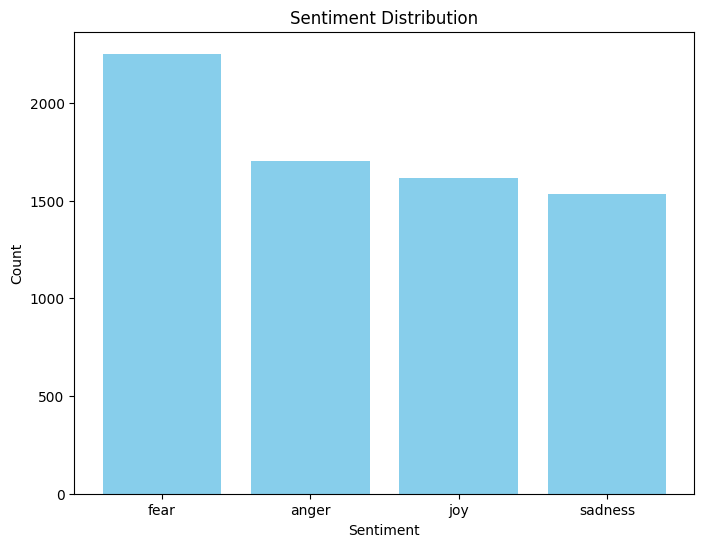

In [ ]:
sentiment_counts = data.sentiment.value_counts()
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values, color='skyblue')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

<ipython-input-5-1170870046>:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([group['Letters'] for name, group in grouped_data], labels=grouped_data.groups.keys())


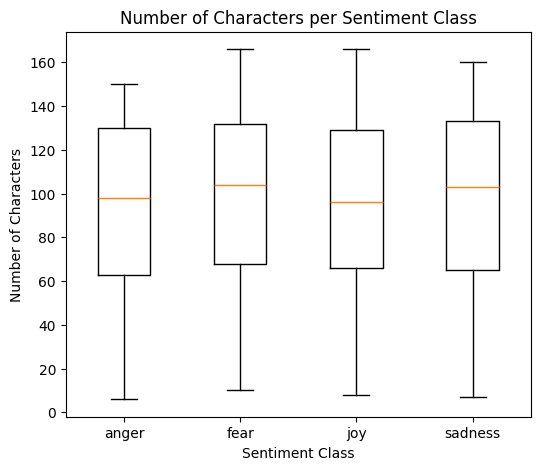

In [ ]:
words = []
letters = []

for index, text in data.iterrows():
    letters.append(len(text.content))
    words.append(len(text.content.split()))

data['Words'] = words
data['Letters'] = letters

grouped_data = data.groupby('sentiment')
avg_words = grouped_data['Words'].mean()
avg_letters = grouped_data['Letters'].mean()

grouped_data = data.groupby('sentiment')

# Boxplot for average number of characters per sentiment class
fig, ax = plt.subplots(figsize=(6, 5))
ax.boxplot([group['Letters'] for name, group in grouped_data], labels=grouped_data.groups.keys())
ax.set_title("Number of Characters per Sentiment Class")
ax.set_xlabel('Sentiment Class')
ax.set_ylabel('Number of Characters')
plt.show()

<ipython-input-6-917470650>:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([group['Words'] for name, group in grouped_data], labels=grouped_data.groups.keys())


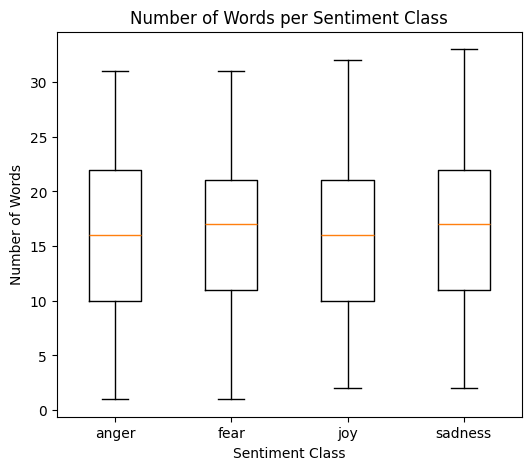

In [ ]:
# Boxplot for average number of words per sentiment class
fig, ax = plt.subplots(figsize=(6, 5))
ax.boxplot([group['Words'] for name, group in grouped_data], labels=grouped_data.groups.keys())
ax.set_title("Number of Words per Sentiment Class")
ax.set_xlabel('Sentiment Class')
ax.set_ylabel('Number of Words')
plt.show()


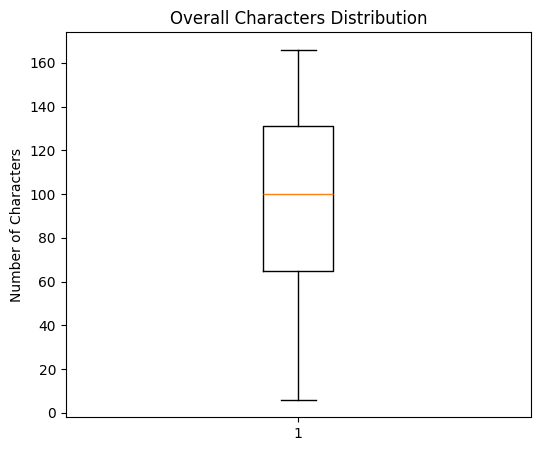

In [ ]:
# Boxplot for characters distribution across all data
fig, ax = plt.subplots(figsize=(6, 5))
ax.boxplot(data['Letters'])
ax.set_title("Overall Characters Distribution")
ax.set_ylabel('Number of Characters')
plt.show()


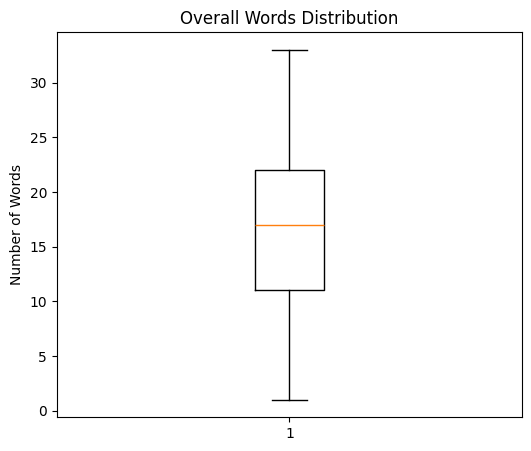

In [ ]:
# Boxplot for words distribution across all data
fig, ax = plt.subplots(figsize=(6, 5))
ax.boxplot(data['Words'])
ax.set_title("Overall Words Distribution")
ax.set_ylabel('Number of Words')
plt.show()


Data Cleaning and Transformation

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab') # Download the missing resource
data_cleaned = preprocessing(data)
data_cleaned = data_cleaned.loc[:,['Sentiment','Content']]
data_copy = data_cleaned.copy()
data_cleaned.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,Sentiment,Content
0,anger,at the point today where if someone says somet...
1,anger,corningfootball it s game day t minus relentless
2,anger,this game has pissed me off more than any othe...
3,anger,spamvicious i ve just found out it s candice a...
4,anger,moocowward mrsajhargreaves melly garybarlow if...


In [ ]:
label_mapping = {"anger": 0, "fear": 1, "joy": 2, "sadness": 3}
data_cleaned['Sentiment'] = data_cleaned['Sentiment'].map(label_mapping)
data_cleaned.head()

,Sentiment,Content
0,0,at the point today where if someone says somet...
1,0,corningfootball it s game day t minus relentless
2,0,this game has pissed me off more than any othe...
3,0,spamvicious i ve just found out it s candice a...
4,0,moocowward mrsajhargreaves melly garybarlow if...


In [ ]:
df_train, df_test = train_test_split(data_cleaned, test_size=0.2, random_state=42, stratify=data_cleaned['Sentiment'])
df_train1 = data_cleaned.copy()
print(f'Training set size: {df_train.shape[0]}')
print(f'Testing set size: {df_test.shape[0]}')

Training set size: 5681
Testing set size: 1421


In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = SentimentDataset(
        texts=df.Content.to_numpy(),
        labels=df.Sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    # turunkan num_workers jadi 2
    return DataLoader(dataset, batch_size=batch_size, num_workers=2, pin_memory=True)


 Model Training - BERT

In [ ]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

MAX_LEN = 64
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def train_epoch(
    model,
    data_loader,
    optimizer,
    device,
    scheduler,
    n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double().item() / n_examples, np.mean(losses)

def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double().item() / n_examples, np.mean(losses)

In [ ]:
EPOCHS = 10
# Removed correct_bias=False as it's not a valid argument for transformers.AdamW
optimizer = AdamW(bert_model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        bert_model,
        train_data_loader,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        bert_model,
        test_data_loader,
        device,
        len(df_test)
    )

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f'Validation loss {val_loss} accuracy {val_acc}')
    print()

Epoch 1/10
----------
Train loss 0.6618662530296966 accuracy 0.74265094173561
Validation loss 0.3353088348266784 accuracy 0.8775510204081632

Epoch 2/10
----------
Train loss 0.26313156535542465 accuracy 0.9077627178313677
Validation loss 0.3325013456594073 accuracy 0.8881069669247009

Epoch 3/10
----------
Train loss 0.1623189257557403 accuracy 0.9420876606231298
Validation loss 0.39712969852307956 accuracy 0.8775510204081632

Epoch 4/10
----------
Train loss 0.10468313665621758 accuracy 0.9574018658686851
Validation loss 0.41478852459538224 accuracy 0.8824771287825475

Epoch 5/10
----------
Train loss 0.0753922404884459 accuracy 0.9670832599894384
Validation loss 0.41208589817279573 accuracy 0.8789584799437016

Epoch 6/10
----------
Train loss 0.05984741991858028 accuracy 0.9695476148565394
Validation loss 0.4576817459506611 accuracy 0.8775510204081632

Epoch 7/10
----------
Train loss 0.05431006504150707 accuracy 0.9725400457665904
Validation loss 0.479799933698201 accuracy 0.877551

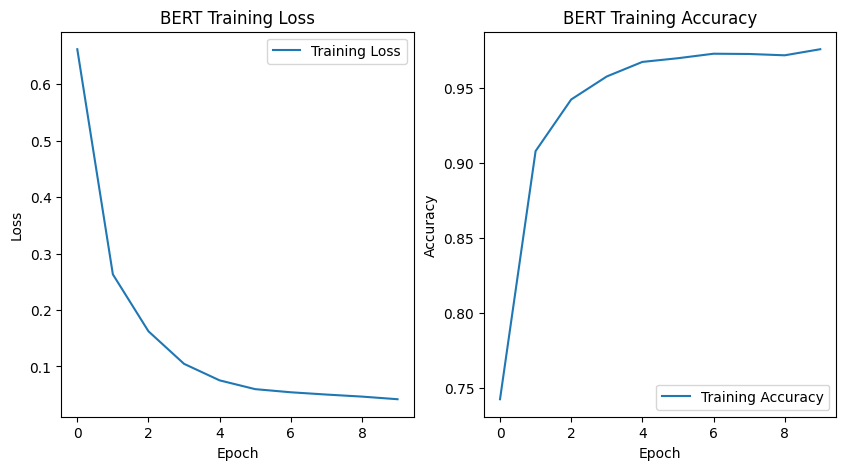

In [ ]:
# Plotting training accuracy and loss

train_losses_np = np.array(train_losses)
train_accuracies_np = np.array(train_accuracies)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_np, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BERT Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_np, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('BERT Training Accuracy')
plt.legend()

plt.show()

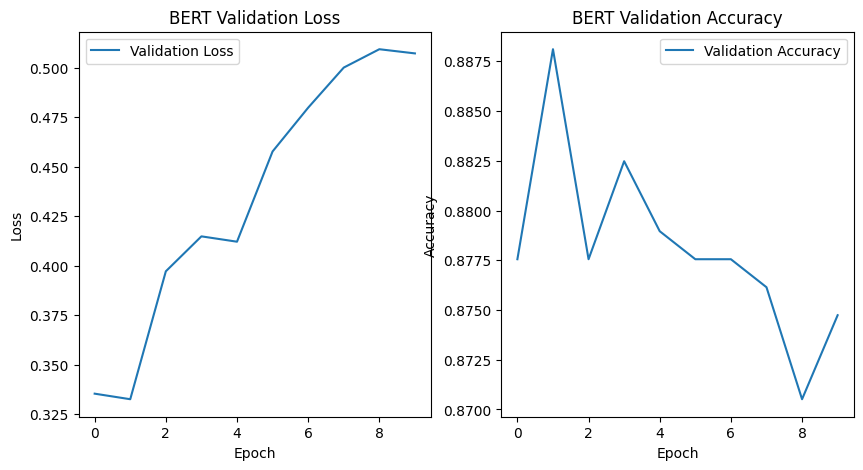

In [ ]:
# Plotting validation loss and accuracy
# val_accuracies = [i.item() for i in val_accuracies]
val_losses_np = np.array(val_losses)
val_accuracies_np = np.array(val_accuracies)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(val_losses_np, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BERT Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies_np, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('BERT Validation Accuracy')
plt.legend()

plt.show()


In [ ]:
# Evaluation on test set
y_texts = []
y_pred = []
y_true = []

with torch.no_grad():
    for d in test_data_loader:
        texts = d["text"]
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)

        outputs = bert_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs.logits, dim=1)

        y_texts.extend(texts)
        y_pred.extend(preds)
        y_true.extend(labels)

y_pred = torch.stack(y_pred).cpu()
y_true = torch.stack(y_true).cpu()

print(classification_report(y_true, y_pred, target_names=['angry', 'fear','joy', 'sadness']))


              precision    recall  f1-score   support

       angry       0.85      0.85      0.85       340
        fear       0.87      0.87      0.87       451
         joy       0.96      0.93      0.94       323
     sadness       0.82      0.84      0.83       307

    accuracy                           0.87      1421
   macro avg       0.88      0.87      0.88      1421
weighted avg       0.88      0.87      0.88      1421



In [ ]:
bert_model.eval()
start_time = time.time()

bert_preds = []
with torch.no_grad():
    for batch in test_data_loader:      # loader untuk BERT
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device).long()
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        bert_preds.extend(preds.cpu())

bert_total = time.time() - start_time
print(f"BERT inference time: {bert_total:.3f}s total / {bert_total/len(df_test):.6f}s per sample")


BERT inference time: 5.711s total / 0.004019s per sample


 Model Training - Roberta

In [ ]:
# Initialize the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

MAX_LEN = 64
BATCH_SIZE = 8

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4).to(device)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double().item() / n_examples, np.mean(losses)

def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double().item() / n_examples, np.mean(losses)


In [ ]:
EPOCHS = 10
# Removed correct_bias=False as it is not a valid argument for transformers.AdamW
optimizer = AdamW(roberta_model.parameters(), lr=1e-5)
total_steps = len(train_data_loader) * EPOCHS

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        roberta_model,
        train_data_loader,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        roberta_model,
        test_data_loader,
        device,
        len(df_test)
    )

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f'Validation loss {val_loss} accuracy {val_acc}')
    print()


# roberta_model = model

Epoch 1/10
----------
Train loss 0.7393712960445595 accuracy 0.702869213166696
Validation loss 0.3830671061165212 accuracy 0.8676988036593948

Epoch 2/10
----------
Train loss 0.34229273847585906 accuracy 0.8759021299067066
Validation loss 0.3382792076137796 accuracy 0.8719211822660099

Epoch 3/10
----------
Train loss 0.24765858994652787 accuracy 0.9118113008273191
Validation loss 0.3489531125334416 accuracy 0.8733286418015482

Epoch 4/10
----------
Train loss 0.18887955509388163 accuracy 0.9317021651117761
Validation loss 0.3659549160583175 accuracy 0.8782547501759325

Epoch 5/10
----------
Train loss 0.14483130589172077 accuracy 0.9470163703573314
Validation loss 0.37961870145963067 accuracy 0.8705137227304715

Epoch 6/10
----------
Train loss 0.1188549689179661 accuracy 0.9561696884351346
Validation loss 0.40920258352789357 accuracy 0.8705137227304715

Epoch 7/10
----------
Train loss 0.09599645540796733 accuracy 0.9603942967787361
Validation loss 0.41315471032618684 accuracy 0.874

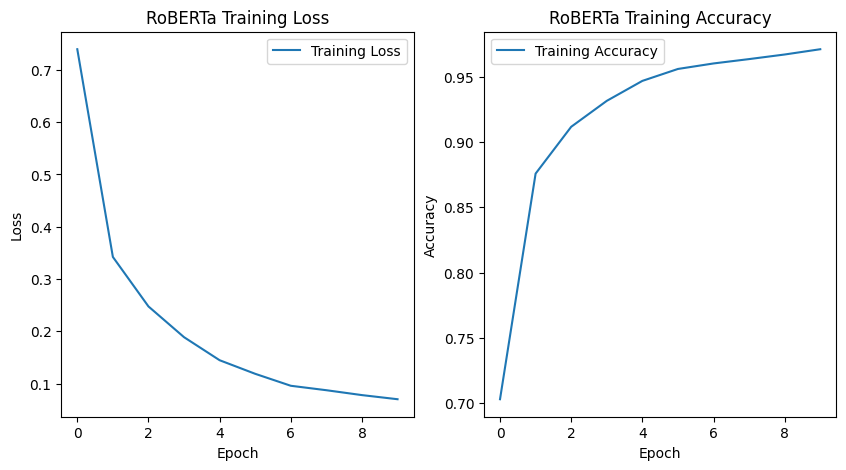

In [ ]:
# Plotting training accuracy and loss

train_losses_np = np.array(train_losses)
train_accuracies_np = np.array(train_accuracies)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses_np, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RoBERTa Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_np, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('RoBERTa Training Accuracy')
plt.legend()

plt.show()

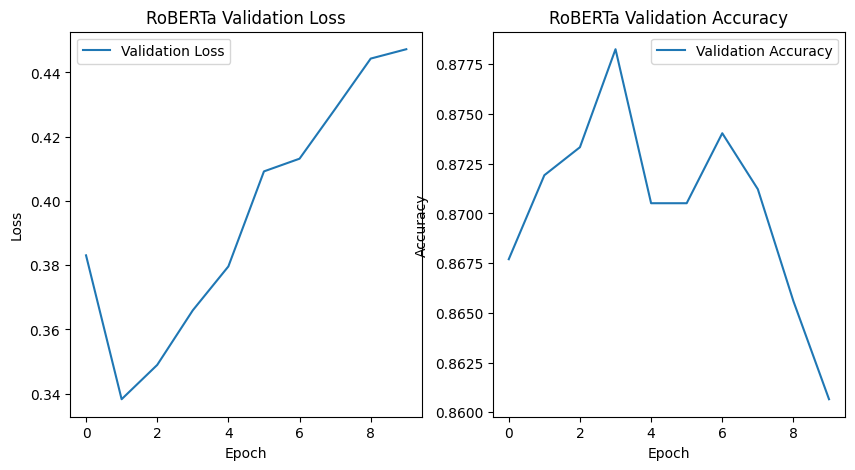

In [ ]:
# Plotting validation loss and accuracy
# val_accuracies = [i.item() for i in val_accuracies]
val_losses_np = np.array(val_losses)
val_accuracies_np = np.array(val_accuracies)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(val_losses_np, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RoBERTa Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies_np, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('RoBERTa Validation Accuracy')
plt.legend()

plt.show()

In [ ]:
# Evaluation on test set
y_texts = []
y_pred = []
y_true = []

with torch.no_grad():
    for d in test_data_loader:
        texts = d["text"]
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)

        outputs = roberta_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs.logits, dim=1)

        y_texts.extend(texts)
        y_pred.extend(preds)
        y_true.extend(labels)

y_pred = torch.stack(y_pred).cpu()
y_true = torch.stack(y_true).cpu()

print(classification_report(y_true, y_pred, target_names=['angry', 'fear','joy', 'sadness']))

              precision    recall  f1-score   support

       angry       0.82      0.86      0.84       340
        fear       0.88      0.85      0.87       451
         joy       0.92      0.93      0.92       323
     sadness       0.81      0.81      0.81       307

    accuracy                           0.86      1421
   macro avg       0.86      0.86      0.86      1421
weighted avg       0.86      0.86      0.86      1421



In [ ]:
# --- RoBERTa inference timing ---
roberta_model.eval()
start_time = time.time()

roberta_preds = []
with torch.no_grad():
    for batch in test_data_loader:    # loader sudah di-assign ulang untuk RoBERTa
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device).long()
        outputs = roberta_model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        roberta_preds.extend(preds.cpu())

roberta_total = time.time() - start_time
print(f"RoBERTa inference time: {roberta_total:.3f}s total / {roberta_total/len(df_test):.6f}s per sample")

RoBERTa inference time: 5.247s total / 0.003693s per sample


In [ ]:
# ----------------------------------------
# Model Training + Inference Timing: DistilBERT
# ----------------------------------------
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# 1) Setup tokenizer & dataloader
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_loader  = create_data_loader(df_test,  tokenizer, MAX_LEN, BATCH_SIZE)

# 2) Init model, optimizer, scheduler
distil_model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=4
).to(device)
optimizer = AdamW(distil_model.parameters(), lr=2e-5)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

# 3) (Optional) Training loop — sama seperti BERT/RoBERTa
for epoch in range(EPOCHS):
    train_epoch(distil_model, train_loader, optimizer, device, scheduler, len(df_train))

# 4) (Optional) Eval + report
distil_model.eval()
y_pred, y_true = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device).long()
        labels = batch["label"].to(device)
        outputs = distil_model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        y_pred.extend(preds.cpu())
        y_true.extend(labels.cpu())
print(classification_report(y_true, y_pred, target_names=['angry','fear','joy','sadness']))

# 5) Inference timing
distil_model.eval()
start = time.time()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device).long()
        _ = distil_model(input_ids=input_ids, attention_mask=attention_mask)
distil_total = time.time() - start
print(f"DistilBERT inference time: {distil_total:.3f}s total / {distil_total/len(df_test):.6f}s per sample")


# ----------------------------------------
# Model Training + Inference Timing: biLSTM
# ----------------------------------------
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim,
                 n_layers=2, bidirectional=True, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            batch_first=True)
        self.dropout = nn.Dropout(dropout)
        fc_in = hidden_dim * (2 if bidirectional else 1)
        self.fc = nn.Linear(fc_in, output_dim)

    def forward(self, input_ids, attention_mask=None):
        # ignore attention_mask here (we assume pad idx = 0)
        embedded = self.dropout(self.embedding(input_ids))
        packed_output, (hidden, cell) = self.lstm(embedded)
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]
        return self.fc(self.dropout(hidden))

# 1) Setup tokenizer (pakai BERT vocab size) & dataloader
bilstm_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_loader = create_data_loader(df_train, bilstm_tokenizer, MAX_LEN, BATCH_SIZE)
test_loader  = create_data_loader(df_test,  bilstm_tokenizer, MAX_LEN, BATCH_SIZE)

# 2) Init model, loss, optimizer
VOCAB_SIZE   = bilstm_tokenizer.vocab_size
EMBED_DIM    = 100
HIDDEN_DIM   = 128
OUTPUT_DIM   = 4
bilstm_model = BiLSTMClassifier(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
criterion    = nn.CrossEntropyLoss().to(device)
optimizer    = Adam(bilstm_model.parameters(), lr=1e-3)

# 3) Training loop
for epoch in range(EPOCHS):
    bilstm_model.train()
    total_loss, correct = 0, 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        labels    = batch["label"].to(device)
        optimizer.zero_grad()
        logits = bilstm_model(input_ids)
        loss   = criterion(logits, labels)
        preds  = torch.argmax(logits, dim=1)
        correct += torch.sum(preds == labels).item()
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    # you can print train loss/acc per epoch if ingin

# 4) (Optional) Eval + report
bilstm_model.eval()
y_pred, y_true = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        labels    = batch["label"].to(device)
        logits    = bilstm_model(input_ids)
        preds     = torch.argmax(logits, dim=1)
        y_pred.extend(preds.cpu())
        y_true.extend(labels.cpu())
print(classification_report(y_true, y_pred, target_names=['angry','fear','joy','sadness']))

# 5) Inference timing
bilstm_model.eval()
start = time.time()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        _ = bilstm_model(input_ids)
bilstm_total = time.time() - start
print(f"biLSTM inference time: {bilstm_total:.3f}s total / {bilstm_total/len(df_test):.6f}s per sample")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


              precision    recall  f1-score   support

       angry       0.85      0.84      0.85       340
        fear       0.86      0.86      0.86       451
         joy       0.93      0.93      0.93       323
     sadness       0.82      0.83      0.82       307

    accuracy                           0.86      1421
   macro avg       0.86      0.86      0.86      1421
weighted avg       0.86      0.86      0.86      1421

DistilBERT inference time: 2.991s total / 0.002105s per sample
              precision    recall  f1-score   support

       angry       0.82      0.79      0.80       340
        fear       0.81      0.87      0.84       451
         joy       0.92      0.91      0.92       323
     sadness       0.81      0.76      0.78       307

    accuracy                           0.84      1421
   macro avg       0.84      0.83      0.84      1421
weighted avg       0.84      0.84      0.84      1421

biLSTM inference time: 1.114s total / 0.000784s per sample


In [ ]:
# ----------------------------------------
# Traditional ML: NB, SVM, Random Forest with inference timing
# ----------------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# 1) Vectorisasi teks
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(df_train.Content)
X_test  = vectorizer.transform(df_test.Content)
y_train = df_train.Sentiment
y_test  = df_test.Sentiment

# 2) Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# NB inference timing
start = time.time()
nb_preds = nb_model.predict(X_test)
nb_total = time.time() - start
print(classification_report(y_test, nb_preds, target_names=['angry','fear','joy','sadness']))
print(f"NB inference time: {nb_total:.3f}s total / {nb_total/len(y_test):.6f}s per sample")

# 3) SVM (linear)
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# SVM inference timing
start = time.time()
svm_preds = svm_model.predict(X_test)
svm_total = time.time() - start
print(classification_report(y_test, svm_preds, target_names=['angry','fear','joy','sadness']))
print(f"SVM inference time: {svm_total:.3f}s total / {svm_total/len(y_test):.6f}s per sample")

# 4) Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

# RF inference timing
start = time.time()
rf_preds = rf_model.predict(X_test)
rf_total = time.time() - start
print(classification_report(y_test, rf_preds, target_names=['angry','fear','joy','sadness']))
print(f"Random Forest inference time: {rf_total:.3f}s total / {rf_total/len(y_test):.6f}s per sample")


              precision    recall  f1-score   support

       angry       0.85      0.75      0.79       340
        fear       0.68      0.96      0.79       451
         joy       0.92      0.80      0.85       323
     sadness       0.83      0.56      0.67       307

    accuracy                           0.78      1421
   macro avg       0.82      0.77      0.78      1421
weighted avg       0.81      0.78      0.78      1421

NB inference time: 0.001s total / 0.000000s per sample
              precision    recall  f1-score   support

       angry       0.88      0.84      0.86       340
        fear       0.84      0.92      0.88       451
         joy       0.93      0.90      0.91       323
     sadness       0.83      0.79      0.81       307

    accuracy                           0.87      1421
   macro avg       0.87      0.86      0.87      1421
weighted avg       0.87      0.87      0.87      1421

SVM inference time: 0.742s total / 0.000522s per sample
              preci

#without stemming and stopwords

Using device: cuda
Imported Packages...
Helper Functions loaded.
Data loaded successfully.
  sentiment                                            content
0     anger  At the point today where if someone says somet...
1     anger  @CorningFootball  IT'S GAME DAY!!!!      T MIN...
2     anger  This game has pissed me off more than any othe...
3     anger  @spamvicious I've just found out it's Candice ...
4     anger  @moocowward @mrsajhargreaves @Melly77 @GaryBar...

--- Running Preprocessing Debug (with Tokenization) ---
Original Text:
'@moocowward @mrsajhargreaves @Melly77 @GaryBarlow if he can't come to my Mum'a 60th after 25k tweets then why should I ðŸ™ˆ  #soreloser'
---------------------------------------------------
[Step 1: Lowercasing]
'@moocowward @mrsajhargreaves @melly77 @garybarlow if he can't come to my mum'a 60th after 25k tweets then why should i ðÿ™ˆ  #soreloser'
---------------------------------------------------
[Step 2: Remove URLs, .com, .es, 'rt']
'@moocowward @mrsa

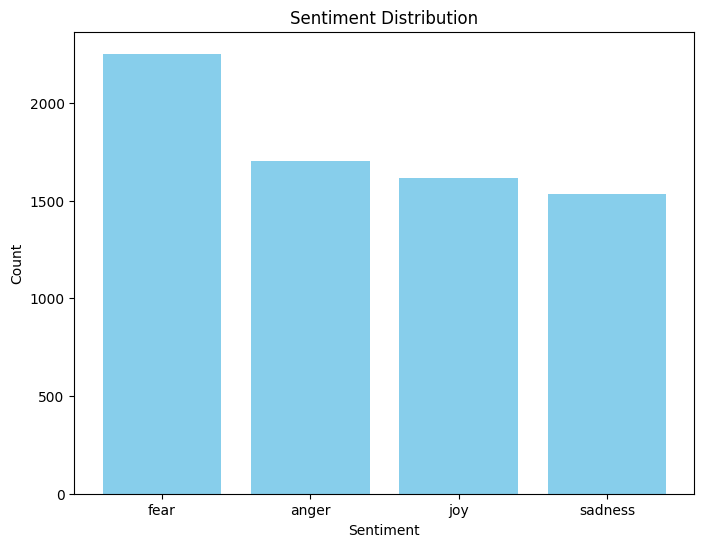

Starting data preprocessing for the entire dataset...
Preprocessing finished.
  Sentiment                                            Content
0     anger  at the point today where if someone says somet...
1     anger   corningfootball it s game day t minus relentless
2     anger  this game has pissed me off more than any othe...
3     anger  spamvicious i ve just found out it s candice a...
4     anger  moocowward mrsajhargreaves melly garybarlow if...
Labels mapped to integers.
   Sentiment                                            Content
0          0  at the point today where if someone says somet...
1          0   corningfootball it s game day t minus relentless
2          0  this game has pissed me off more than any othe...
3          0  spamvicious i ve just found out it s candice a...
4          0  moocowward mrsajhargreaves melly garybarlow if...
Training set size: 5681
Testing set size: 1421

--- Starting BERT Training ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Train loss 0.8487 accuracy 0.6509
Validation loss 0.4414 accuracy 0.8501
Epoch 2/3
Train loss 0.3202 accuracy 0.8877
Validation loss 0.3852 accuracy 0.8698
Epoch 3/3
Train loss 0.2088 accuracy 0.9273
Validation loss 0.3817 accuracy 0.8600

BERT Classification Report:
              precision    recall  f1-score   support

       anger       0.87      0.83      0.85       340
        fear       0.84      0.86      0.85       451
         joy       0.92      0.92      0.92       323
     sadness       0.82      0.83      0.82       307

    accuracy                           0.86      1421
   macro avg       0.86      0.86      0.86      1421
weighted avg       0.86      0.86      0.86      1421


--- Starting RoBERTa Training ---


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
Train loss 0.9072 accuracy 0.6143
Validation loss 0.4684 accuracy 0.8318
Epoch 2/3
Train loss 0.4117 accuracy 0.8535
Validation loss 0.4154 accuracy 0.8536
Epoch 3/3
Train loss 0.3177 accuracy 0.8870
Validation loss 0.3955 accuracy 0.8564

RoBERTa Classification Report:
              precision    recall  f1-score   support

       anger       0.87      0.81      0.84       340
        fear       0.85      0.86      0.85       451
         joy       0.89      0.92      0.91       323
     sadness       0.82      0.83      0.83       307

    accuracy                           0.86      1421
   macro avg       0.86      0.86      0.86      1421
weighted avg       0.86      0.86      0.86      1421


--- Starting Traditional ML Models ---

Training Naive Bayes...
Naive Bayes Classification Report:
              precision    recall  f1-score   support

       anger       0.85      0.76      0.80       340
        fear       0.67      0.95      0.79       451
         joy       0.

In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import classification_report
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import time

from torch import nn
from transformers import BertConfig
import torch.nn.functional as F
from torch.optim import AdamW

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


import re
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from unicodedata import normalize
# Lemmatizer and stopwords are no longer needed
# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import stopwords

import random

def set_seed(seed):
    random.seed(seed)
    # np.random.seed(seed)
    # torch.manual_seed(seed)
    # if torch.cuda.is_available():
    #     torch.cuda.manual_seed_all(seed)
    #     torch.backends.cudnn.deterministic = True
    #     torch.backends.cudnn.benchmark = False

# Set seed for reproducibility
set_seed(22)

print("Imported Packages...")

# Download necessary NLTK data
import nltk
nltk.download('punkt', quiet=True) # Needed for word_tokenize


# Helper Functions

def preprocessing(data):
    """
    Preprocess tweets by cleaning and tokenizing them.
    This version REMOVES stopword removal and lemmatization, but KEEPS tokenization.

    Args:
    - data (DataFrame): DataFrame containing tweets and sentiments.

    Returns:
    - data (DataFrame): Preprocessed DataFrame with cleaned tweets.
    """

    tweets = []
    sentiment = []

    for index, tweet in data.iterrows():
        # Make a copy to avoid SettingWithCopyWarning
        tweet_content = tweet.content
        tweet_clean = str(tweet_content).lower()

        words_cleaned = " ".join([word for word in tweet_clean.split()
                                  if 'http://' not in word
                                  and 'https://' not in word
                                  and '.com' not in word
                                  and '.es' not in word
                                  and word != 'rt'])

        # Remove only # and @ characters
        tweet_clean = re.sub(r'[@#]', '', words_cleaned)

        # Perform additional cleaning steps
        tweet_clean = re.sub(r'\b([jh]*[aeiou]*[jh]+[aeiou]*)*\b', "", tweet_clean)
        tweet_clean = re.sub(r'(.)\1{2,}', r'\1', tweet_clean)
        tweet_clean = re.sub(
            r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1",
            normalize("NFD", tweet_clean), 0, re.I)
        tweet_clean = re.sub("[^a-zA-Z]", " ", tweet_clean)
        tweet_clean = re.sub("\t", " ", tweet_clean)
        tweet_clean = re.sub(" +", " ", tweet_clean)
        tweet_clean = tweet_clean.strip()
        tweet_clean = re.sub("\n", "", tweet_clean)

        # --- MODIFICATION START ---
        # Tokenize the cleaned text
        tokens = word_tokenize(tweet_clean)

        # Join tokens back into a string. Stopword and lemmatization are removed.
        final_text = " ".join(tokens)

        sentiment.append(tweet.sentiment)
        tweets.append(final_text)
        # --- MODIFICATION END ---


    new_data = pd.DataFrame({
        'Sentiment': sentiment,
        'Content': tweets
    })

    return new_data


def debug_preprocess_steps(sample_text):
    """
    Shows the result of each preprocessing step for a single text sample.
    This version is modified to show tokenization but exclude stopword/lemmatization.

    Args:
    - sample_text (str): A single string of text (e.g., one tweet).
    """

    print("===================================================")
    print(f"Original Text:\n'{sample_text}'")
    print("---------------------------------------------------")

    # --- Step 1: Lowercasing ---
    text_clean = sample_text.lower()
    print(f"[Step 1: Lowercasing]\n'{text_clean}'")
    print("---------------------------------------------------")

    # --- Step 2: Remove URLs, domains, and 'rt' ---
    words_cleaned = " ".join([word for word in text_clean.split()
                              if 'http://' not in word
                              and 'https://' not in word
                              and '.com' not in word
                              and '.es' not in word
                              and word != 'rt'])
    text_clean = words_cleaned
    print(f"[Step 2: Remove URLs, .com, .es, 'rt']\n'{text_clean}'")
    print("---------------------------------------------------")

    # --- Step 3: Remove '#' and '@' characters ---
    text_clean = re.sub(r'[@#]', '', text_clean)
    print(f"[Step 3: Remove '#' and '@' characters]\n'{text_clean}'")
    print("---------------------------------------------------")

    # --- Step 4: Various Regex Cleaning Steps ---
    print("[Step 4: Regex Cleaning]")
    step_4a_result = re.sub(r'\b([jh]*[aeiou]*[jh]+[aeiou]*)*\b', "", text_clean)
    print(f"  [4a: Remove laughing patterns]\n  '{step_4a_result}'")
    step_4b_result = re.sub(r'(.)\1{2,}', r'\1', step_4a_result)
    print(f"  [4b: Normalize repeated characters]\n  '{step_4b_result}'")
    step_4c_result = re.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1",
        normalize("NFD", step_4b_result), 0, re.I)
    print(f"  [4c: Remove accents]\n  '{step_4c_result}'")
    step_4d_result = re.sub("[^a-zA-Z]", " ", step_4c_result)
    print(f"  [4d: Remove non-alphabetic chars]\n  '{step_4d_result}'")
    step_4e_result = re.sub(" +", " ", step_4d_result).strip()
    text_clean = step_4e_result
    print(f"  [4e: Normalize whitespace]\n  '{text_clean}'")
    print("---------------------------------------------------")

    # --- Step 5: Tokenization ---
    tokens = word_tokenize(text_clean)
    print(f"[Step 5: Tokenization]\n{tokens}")
    print("---------------------------------------------------")

    # Join tokens to form the final text
    final_text = " ".join(tokens)
    print(f"[Final Result (after all cleaning and tokenization)]\n'{final_text}'")
    print("===================================================")


print("Helper Functions loaded.")

# Reading Data
try:
    data = pd.read_csv("eng_dataset.csv")
    data.drop(["ID"], axis=1, inplace=True, errors='ignore')
    print("Data loaded successfully.")
    print(data.head())

    # --- DEBUGGING EXAMPLE ---
    sample_tweet_for_debug = data.content.iloc[4]

    print("\n--- Running Preprocessing Debug (with Tokenization) ---")
    debug_preprocess_steps(sample_tweet_for_debug)
    print("--- End of Preprocessing Debug ---\n")

except FileNotFoundError:
    print("Error: eng_dataset.csv not found. Please ensure the file is in the correct directory.")
    data = pd.DataFrame({
        'content': ["I am so happy today", "I feel really sad", "This is making me angry", "I am afraid of the dark"],
        'sentiment': ['joy', 'sadness', 'anger', 'fear']
    })
    print("Created a dummy dataframe to proceed.")


# Data Exploration
sentiment_counts = data.sentiment.value_counts()
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values, color='skyblue')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()


# Data Cleaning and Transformation
print("Starting data preprocessing for the entire dataset...")
data_cleaned = preprocessing(data.copy())
print("Preprocessing finished.")
print(data_cleaned.head())


label_mapping = {"anger": 0, "fear": 1, "joy": 2, "sadness": 3}
data_cleaned['Sentiment'] = data_cleaned['Sentiment'].map(label_mapping)
print("Labels mapped to integers.")
print(data_cleaned.head())

# Train-Test Split
df_train, df_test = train_test_split(data_cleaned, test_size=0.2, random_state=22, stratify=data_cleaned['Sentiment'])
print(f'Training set size: {df_train.shape[0]}')
print(f'Testing set size: {df_test.shape[0]}')

# Dataset and DataLoader
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = str(self.texts[index])
        label = self.labels[index]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = SentimentDataset(
        texts=df.Content.to_numpy(),
        labels=df.Sentiment.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(dataset, batch_size=batch_size, num_workers=0)


# Generic Training and Evaluation Functions
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double().item() / n_examples, np.mean(losses)

def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double().item() / n_examples, np.mean(losses)


# --- Model Training: BERT ---
print("\n--- Starting BERT Training ---")
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 64
BATCH_SIZE = 16
EPOCHS = 3

train_data_loader = create_data_loader(df_train, tokenizer_bert, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer_bert, MAX_LEN, BATCH_SIZE)

bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4).to(device)
optimizer = AdamW(bert_model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_acc, train_loss = train_epoch(
        bert_model, train_data_loader, optimizer, device, scheduler, len(df_train)
    )
    print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f}')
    val_acc, val_loss = eval_model(
        bert_model, test_data_loader, device, len(df_test)
    )
    print(f'Validation loss {val_loss:.4f} accuracy {val_acc:.4f}')


# Evaluation on test set
y_pred, y_true = [], []
with torch.no_grad():
    for d in test_data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        y_pred.extend(preds)
        y_true.extend(labels)

y_pred = torch.stack(y_pred).cpu()
y_true = torch.stack(y_true).cpu()

print("\nBERT Classification Report:")
print(classification_report(y_true, y_pred, target_names=['anger', 'fear','joy', 'sadness'], zero_division=0))


# --- Model Training: RoBERTa ---
print("\n--- Starting RoBERTa Training ---")
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')

train_data_loader_roberta = create_data_loader(df_train, tokenizer_roberta, MAX_LEN, BATCH_SIZE)
test_data_loader_roberta = create_data_loader(df_test, tokenizer_roberta, MAX_LEN, BATCH_SIZE)

roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4).to(device)
optimizer = AdamW(roberta_model.parameters(), lr=1e-5)
total_steps = len(train_data_loader_roberta) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_acc, train_loss = train_epoch(
        roberta_model, train_data_loader_roberta, optimizer, device, scheduler, len(df_train)
    )
    print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f}')
    val_acc, val_loss = eval_model(
        roberta_model, test_data_loader_roberta, device, len(df_test)
    )
    print(f'Validation loss {val_loss:.4f} accuracy {val_acc:.4f}')


# RoBERTa Evaluation
y_pred_roberta, y_true_roberta = [], []
with torch.no_grad():
    for d in test_data_loader_roberta:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)
        outputs = roberta_model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        y_pred_roberta.extend(preds)
        y_true_roberta.extend(labels)

y_pred_roberta = torch.stack(y_pred_roberta).cpu()
y_true_roberta = torch.stack(y_true_roberta).cpu()

print("\nRoBERTa Classification Report:")
print(classification_report(y_true_roberta, y_pred_roberta, target_names=['anger', 'fear','joy', 'sadness'], zero_division=0))

# --- Traditional ML Models ---
print("\n--- Starting Traditional ML Models ---")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# 1) Vectorize text
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(df_train.Content)
X_test_tfidf  = vectorizer.transform(df_test.Content)
y_train = df_train.Sentiment
y_test  = df_test.Sentiment

# 2) Naive Bayes
print("\nTraining Naive Bayes...")
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_preds = nb_model.predict(X_test_tfidf)
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_preds, target_names=['anger','fear','joy','sadness'], zero_division=0))

# 3) SVM (linear)
print("\nTraining SVM...")
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)
svm_preds = svm_model.predict(X_test_tfidf)
print("SVM Classification Report:")
print(classification_report(y_test, svm_preds, target_names=['anger','fear','joy','sadness'], zero_division=0))

# 4) Random Forest
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=22)
rf_model.fit(X_train_tfidf, y_train)
rf_preds = rf_model.predict(X_test_tfidf)
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_preds, target_names=['anger','fear','joy','sadness'], zero_division=0))

print("\n--- All models trained and evaluated. ---")


#without preprocesing manual

Using device: cuda
Imported Packages...
Data loaded and columns renamed successfully.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


--- Running Tokenizer Pipeline Debug ---

--- Debugging Pipeline: Raw Text -> Transformer Tokenizer ---
[TAHAP 1: Teks Asli dari Dataset]
'@moocowward @mrsajhargreaves @Melly77 @GaryBarlow if he can't come to my Mum'a 60th after 25k tweets then why should I ðŸ™ˆ  #soreloser'

------------------------- Mulai Proses oleh Tokenizer -------------------------

  - Hasil Tokenisasi (Sub-words):
    ['[CLS]', '@', 'mo', '##oco', '##w', '##ward', '@', 'mrs', '##aj', '##har', '##gre', '##aves', '@', 'mel', '##ly', '##7', '##7', '@', 'gary', '##bar', '##low', 'if', 'he', 'can', "'", 't', 'come', 'to', 'my', 'mum', "'", 'a', '60th', 'after', '25', '##k', 't', '##wee', '##ts', 'then', 'why', 'should', 'i', '[UNK]', '#', 'sore', '##los', '##er', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']

  - Hasil Input IDs:
    [101, 1030, 9587, 24163, 2860, 7652, 1030, 3680, 13006, 8167, 17603, 21055, 1030, 1146

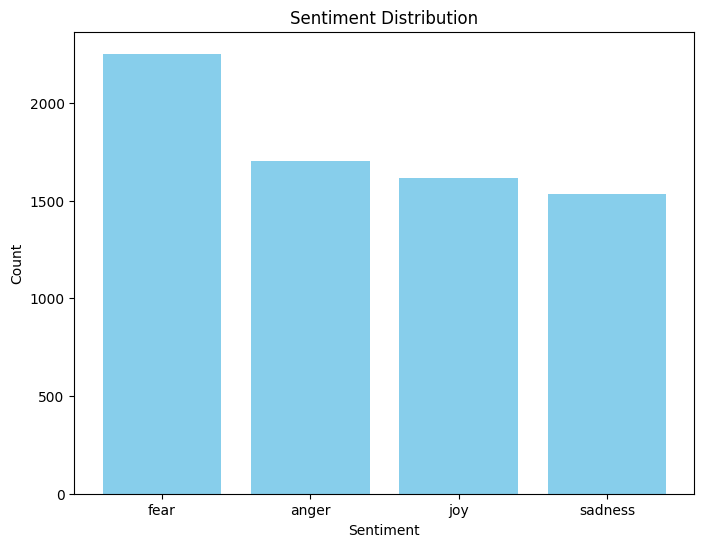

Labels mapped to integers.
Training set size: 5681
Testing set size: 1421

--- Memulai Training Model Tradisional ---

--- Training Naive Bayes ---
Naive Bayes Classification Report:
              precision    recall  f1-score   support

       anger       0.85      0.83      0.84       340
        fear       0.76      0.92      0.83       451
         joy       0.91      0.87      0.89       323
     sadness       0.85      0.64      0.73       307

    accuracy                           0.83      1421
   macro avg       0.84      0.82      0.82      1421
weighted avg       0.83      0.83      0.83      1421


--- Training SVM ---
SVM Classification Report:
              precision    recall  f1-score   support

       anger       0.86      0.84      0.85       340
        fear       0.83      0.91      0.87       451
         joy       0.96      0.91      0.94       323
     sadness       0.84      0.79      0.81       307

    accuracy                           0.87      1421
   macr

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT Epoch 1/3
BERT Epoch 2/3
BERT Epoch 3/3

--- BERT Classification Report ---
              precision    recall  f1-score   support

       anger       0.86      0.84      0.85       340
        fear       0.86      0.86      0.86       451
         joy       0.91      0.92      0.91       323
     sadness       0.83      0.82      0.83       307

    accuracy                           0.86      1421
   macro avg       0.86      0.86      0.86      1421
weighted avg       0.86      0.86      0.86      1421


--- Starting RoBERTa Training ---


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RoBERTa Epoch 1/3
RoBERTa Epoch 2/3
RoBERTa Epoch 3/3

--- RoBERTa Classification Report ---
              precision    recall  f1-score   support

       anger       0.86      0.83      0.84       340
        fear       0.84      0.87      0.85       451
         joy       0.88      0.91      0.89       323
     sadness       0.86      0.83      0.84       307

    accuracy                           0.86      1421
   macro avg       0.86      0.86      0.86      1421
weighted avg       0.86      0.86      0.86      1421


--- All models trained and evaluated. ---


In [ ]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup, \
                     RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
# Import train_test_split
from sklearn.model_selection import train_test_split
import time
from torch.optim import AdamW

# For Traditional ML models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import random

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(22)
print("Imported Packages...")

def debug_tokenizer_pipeline(sample_text, tokenizer):
    """
    Shows how a Transformer tokenizer processes raw text directly.
    """
    print("\n" + "="*70)
    print(f"--- Debugging Pipeline: Raw Text -> Transformer Tokenizer ---")
    print("="*70)
    print(f"[TAHAP 1: Teks Asli dari Dataset]\n'{sample_text}'\n")
    print("-" * 25, "Mulai Proses oleh Tokenizer", "-"*25)
    encoding = tokenizer.encode_plus(
        sample_text,
        add_special_tokens=True,
        max_length=64,
        padding='max_length',
        truncation=True,
        return_attention_mask=True
    )
    final_tokens = tokenizer.convert_ids_to_tokens(encoding['input_ids'])
    print(f"\n  - Hasil Tokenisasi (Sub-words):\n    {final_tokens}\n")
    print(f"  - Hasil Input IDs:\n    {encoding['input_ids']}\n")
    print(f"  - Hasil Attention Mask:\n    {encoding['attention_mask']}")
    print("-" * 25, "Selesai Proses Tokenizer", "-"*25)
    print("\nKESIMPULAN:")
    print("Teks asli langsung diproses oleh tokenizer menjadi token-token yang dipahami model.")
    print("="*70 + "\n")


# Reading Data
try:
    data = pd.read_csv("eng_dataset.csv")
    data.drop(["ID"], axis=1, inplace=True, errors='ignore')
    data.rename(columns={'content': 'Content', 'sentiment': 'Sentiment'}, inplace=True)
    print("Data loaded and columns renamed successfully.")

    debug_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    sample_tweet_for_debug = data.Content.iloc[4]
    print("\n--- Running Tokenizer Pipeline Debug ---")
    debug_tokenizer_pipeline(sample_tweet_for_debug, debug_tokenizer)
    print("--- End of Tokenizer Pipeline Debug ---\n")

except FileNotFoundError:
    print("Error: eng_dataset.csv not found. Please ensure the file is in the correct directory.")
    data = pd.DataFrame({
        'Content': ["I am so happy today", "I feel really sad", "This is making me angry", "I am afraid of the dark"],
        'Sentiment': ['joy', 'sadness', 'anger', 'fear']
    })
    print("Created a dummy dataframe to proceed.")


# Data Exploration
sentiment_counts = data.Sentiment.value_counts()
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values, color='skyblue')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

label_mapping = {"anger": 0, "fear": 1, "joy": 2, "sadness": 3}
data['Sentiment_Encoded'] = data['Sentiment'].map(label_mapping)
print("Labels mapped to integers.")

# Train-Test Split using the original text
df_train, df_test = train_test_split(data, test_size=0.2, random_state=22, stratify=data['Sentiment_Encoded'])
print(f'Training set size: {df_train.shape[0]}')
print(f'Testing set size: {df_test.shape[0]}')


# ===================================================================
# 1. MODEL-MODEL TRADISIONAL (CLASSICAL ML)
# ===================================================================
print("\n--- Memulai Training Model Tradisional ---")
# TfidfVectorizer akan menangani tokenisasi dasar dan pembuatan fitur dari teks mentah
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')

# Gunakan kolom 'Content' (teks mentah) untuk training
X_train_tfidf = vectorizer.fit_transform(df_train['Content'])
X_test_tfidf = vectorizer.transform(df_test['Content'])

y_train = df_train['Sentiment_Encoded']
y_test = df_test['Sentiment_Encoded']
target_names_ml = ['anger', 'fear', 'joy', 'sadness']

# Latih dan evaluasi setiap model
for name, model in [('Naive Bayes', MultinomialNB()), ('SVM', SVC(kernel='linear')), ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42))]:
    print(f"\n--- Training {name} ---")
    model.fit(X_train_tfidf, y_train)
    preds = model.predict(X_test_tfidf)
    print(f"{name} Classification Report:")
    print(classification_report(y_test, preds, target_names=target_names_ml, zero_division=0))

# ===================================================================
# 2. MODEL-MODEL TRANSFORMER (DEEP LEARNING)
# ===================================================================

# Dataset and DataLoader
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, index):
        text = str(self.texts[index])
        label = self.labels[index]
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            padding='max_length', truncation=True, return_token_type_ids=False,
            return_attention_mask=True, return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    dataset = SentimentDataset(
        texts=df.Content.to_numpy(),
        labels=df.Sentiment_Encoded.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(dataset, batch_size=batch_size, num_workers=0)


# Generic Training and Evaluation Functions
def train_epoch(model, data_loader, optimizer, device, scheduler):
    model = model.train()
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

def eval_and_report(model, data_loader, device, model_name, target_names):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            all_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    print(f"\n--- {model_name} Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=target_names, zero_division=0))

# --- Model Training: BERT ---
print("\n--- Starting BERT Training ---")
tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3

train_data_loader = create_data_loader(df_train, tokenizer_bert, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer_bert, MAX_LEN, BATCH_SIZE)

bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapping)).to(device)
optimizer = AdamW(bert_model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)

for epoch in range(EPOCHS):
    print(f'BERT Epoch {epoch + 1}/{EPOCHS}')
    train_epoch(bert_model, train_data_loader, optimizer, device, scheduler)

# Evaluation
eval_and_report(bert_model, test_data_loader, device, "BERT", target_names_ml)

# --- Model Training: RoBERTa ---
print("\n--- Starting RoBERTa Training ---")
tokenizer_roberta = RobertaTokenizer.from_pretrained('roberta-base')

train_data_loader_roberta = create_data_loader(df_train, tokenizer_roberta, MAX_LEN, BATCH_SIZE)
test_data_loader_roberta = create_data_loader(df_test, tokenizer_roberta, MAX_LEN, BATCH_SIZE)

roberta_model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(label_mapping)).to(device)
optimizer_roberta = AdamW(roberta_model.parameters(), lr=1e-5)
total_steps_roberta = len(train_data_loader_roberta) * EPOCHS
scheduler_roberta = get_linear_schedule_with_warmup(
    optimizer_roberta, num_warmup_steps=0, num_training_steps=total_steps_roberta
)

for epoch in range(EPOCHS):
    print(f'RoBERTa Epoch {epoch + 1}/{EPOCHS}')
    train_epoch(roberta_model, train_data_loader_roberta, optimizer_roberta, device, scheduler_roberta)

# RoBERTa Evaluation
eval_and_report(roberta_model, test_data_loader_roberta, device, "RoBERTa", target_names_ml)

print("\n--- All models trained and evaluated. ---")


#FINAL


In [ ]:
# ====== Import Pustaka yang Dibutuhkan ======

import pandas as pd
import numpy as np
import torch
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
from unicodedata import normalize
import nltk
import tensorflow

import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Scikit-learn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix

# PyTorch & Transformers
import transformers
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, AdamW
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    DistilBertTokenizer, DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup
)

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Menggunakan device: {device}")

print(f"PyTorch version: {torch.__version__}")
print(f"TensorFlow version: {tensorflow.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

# ====== 1. Fungsi Preprocessing ======
def preprocessing(text: str) -> str:
    """
    Membersihkan dan memproses teks mentah.
    """
    text = text.lower()
    text = " ".join(w for w in text.split()
                    if 'http://' not in w and 'https://' not in w
                    and '.com' not in w and '.es' not in w and w!='rt')
    text = re.sub(r'[@#]', '', text)
    text = re.sub(r'\b([jh]*[aeiou]*[jh]+[aeiou]*)*\b','',text)
    text = re.sub(r'(.)\1{2,}',r'\1', text)
    text = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+",
                  r"\1", normalize("NFD", text), flags=re.I)
    text = re.sub("[^a-zA-Z]"," ", text)
    text = re.sub(r"\s+"," ", text).strip()

    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    stemmer = SnowballStemmer('english')

    return " ".join(stemmer.stem(w) for w in tokens if w not in stop_words)

# ====== 2. Memuat dan Memproses Data ======
# Ganti dengan path yang benar jika file tidak ada di direktori yang sama
try:
    df = pd.read_csv("eng_dataset.csv")
    df.drop(["ID"], axis=1, inplace=True, errors='ignore')
except FileNotFoundError:
    print("Error: Pastikan file 'eng_dataset.csv' berada di direktori yang sama.")
    # Exit atau handle error sesuai kebutuhan
    exit()

print("--- Data Asli (Sebelum Preprocessing) ---")
print(df.head().to_markdown(index=False))

# Terapkan fungsi preprocessing
df['Processed_Content'] = df['content'].apply(preprocessing)

print("\n--- Data Setelah Preprocessing ---")
# Menampilkan kolom asli dan yang sudah diproses untuk perbandingan
print(df[['content', 'Processed_Content', 'sentiment']].head().to_markdown(index=False))

# Mapping label ke numerik
emotion_labels = {"joy": 0, "sadness": 1, "anger": 2, "fear": 3}
df['sentiment_encoded'] = df['sentiment'].map(emotion_labels)

# ====== 3. Pembagian Data (80:20) ======
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment_encoded']
)

print(f"\nUkuran Training Set: {df_train.shape[0]}")
print(f"Ukuran Testing Set: {df_test.shape[0]}")

# ====== Analisis Persebaran Emosi Setelah Split ======
print("\n--- Persebaran Emosi Setelah Split ---")

# Persebaran di Training Set
print("Training Set Distribution:")
train_emotion_dist = df_train['sentiment'].value_counts().sort_index()
print(train_emotion_dist)
print(f"Training Set Percentages:")
for emotion, count in train_emotion_dist.items():
    percentage = (count / len(df_train)) * 100
    print(f"{emotion}: {count} samples ({percentage:.2f}%)")

print("\nTesting Set Distribution:")
test_emotion_dist = df_test['sentiment'].value_counts().sort_index()
print(test_emotion_dist)
print(f"Testing Set Percentages:")
for emotion, count in test_emotion_dist.items():
    percentage = (count / len(df_test)) * 100
    print(f"{emotion}: {count} samples ({percentage:.2f}%)")

# Visualisasi persebaran emosi
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training Set
train_emotion_dist.plot(kind='bar', ax=axes[0], color='skyblue', alpha=0.7)
axes[0].set_title('Training Set - Emotion Distribution')
axes[0].set_xlabel('Emotion')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Testing Set
test_emotion_dist.plot(kind='bar', ax=axes[1], color='lightcoral', alpha=0.7)
axes[1].set_title('Testing Set - Emotion Distribution')
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Ringkasan total
print(f"\nTotal Dataset: {len(df)} samples")
print(f"Training Set: {len(df_train)} samples ({(len(df_train)/len(df)*100):.1f}%)")
print(f"Testing Set: {len(df_test)} samples ({(len(df_test)/len(df)*100):.1f}%)")

# ====== 4. Ekstraksi Fitur & Model Machine Learning ======
print("\n--- Melatih Model Machine Learning ---")

# Ekstraksi Fitur TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['Processed_Content'])
X_test_tfidf = tfidf_vectorizer.transform(df_test['Processed_Content'])
y_train = df_train['sentiment_encoded']
y_test = df_test['sentiment_encoded']

# Fungsi untuk evaluasi model ML
def evaluate_ml_model(model, X_test, y_test, model_name):
    start_time = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_time

    print(f"--- {model_name} ---")
    print(classification_report(y_test, y_pred, target_names=emotion_labels.keys()))

    # Metrik individu
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Inference Time: {inference_time:.4f}s")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.keys(), yticklabels=emotion_labels.keys())
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Label Asli')
    plt.xlabel('Label Prediksi')
    plt.show()

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
evaluate_ml_model(nb_model, X_test_tfidf, y_test, "Naive Bayes")

# SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_tfidf, y_train)
evaluate_ml_model(svm_model, X_test_tfidf, y_test, "Support Vector Machine")

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_tfidf, y_train)
evaluate_ml_model(rf_model, X_test_tfidf, y_test, "Random Forest")


# ====== 5. Model Deep Learning ======
print("\n--- Melatih Model Deep Learning ---")

# Helper classes and functions for PyTorch
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = EmotionDataset(
        texts=df.Processed_Content.to_numpy(),
        labels=df.sentiment_encoded.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=2)

def train_dl_epoch(model, data_loader, optimizer, device, scheduler):
    model = model.train()
    losses = []
    correct_predictions = 0
    total_samples = 0 # Keep track of total samples
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        total_samples += labels.size(0) # Add batch size to total samples

        loss.backward()
        optimizer.step()
        scheduler.step()

    # Move to CPU and get item for scalar values
    return correct_predictions.double().cpu().item() / total_samples, np.mean(losses)

def eval_dl_model(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0
    total_samples = 0 # Keep track of total samples
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            total_samples += labels.size(0) # Add batch size to total samples

    # Move to CPU and get item for scalar values
    return correct_predictions.double().cpu().item() / total_samples, np.mean(losses)

def get_predictions(model, data_loader, device):
    model = model.eval()
    predictions = []
    real_values = []
    start_time = time.time()
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            predictions.extend(preds.cpu().numpy()) # Move predictions to CPU
            real_values.extend(labels.cpu().numpy()) # Move labels to CPU

    inference_time = time.time() - start_time
    return predictions, real_values, inference_time

def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    # Ensure data is on CPU before plotting
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'Accuracy History - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
     # Ensure data is on CPU before plotting
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Loss History - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- BiLSTM ---
print("\n--- BiLSTM ---")

# Hyperparameters
VOCAB_SIZE = 10000
EMBED_DIM = 128
MAX_LEN_BILSTM = 128
HIDDEN_DIM = 128
OUTPUT_DIM = len(emotion_labels)
EPOCHS_BILSTM = 20
LEARNING_RATE_BILSTM = 1e-3

# BiLSTM Model Definition
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=True, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, input_ids, attention_mask=None): # attention_mask is for compatibility
        embedded = self.embedding(input_ids)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        # Ensure hidden state is on CPU before concatenation if needed later for CPU ops, but for FC it's fine on GPU
        # For this model, the hidden state remains on the device for the linear layer
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)

# Tokenizer untuk BiLSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer_bilstm = Tokenizer(num_words=VOCAB_SIZE, oov_token="<unk>")
tokenizer_bilstm.fit_on_texts(df_train['Processed_Content'])
X_train_seq = pad_sequences(tokenizer_bilstm.texts_to_sequences(df_train['Processed_Content']), maxlen=MAX_LEN_BILSTM)
X_test_seq = pad_sequences(tokenizer_bilstm.texts_to_sequences(df_test['Processed_Content']), maxlen=MAX_LEN_BILSTM)
y_train_tensor = torch.tensor(df_train['sentiment_encoded'].values, dtype=torch.long)
y_test_tensor = torch.tensor(df_test['sentiment_encoded'].values, dtype=torch.long)

# DataLoader untuk BiLSTM
train_data_bilstm = torch.utils.data.TensorDataset(torch.tensor(X_train_seq, dtype=torch.long), y_train_tensor)
train_loader_bilstm = DataLoader(train_data_bilstm, batch_size=32, shuffle=True)
test_data_bilstm = torch.utils.data.TensorDataset(torch.tensor(X_test_seq, dtype=torch.long), y_test_tensor)
test_loader_bilstm = DataLoader(test_data_bilstm, batch_size=32)

# Training BiLSTM
model_bilstm = BiLSTMClassifier(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
optimizer_bilstm = Adam(model_bilstm.parameters(), lr=LEARNING_RATE_BILSTM)
criterion_bilstm = nn.CrossEntropyLoss().to(device)

history_bilstm = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(EPOCHS_BILSTM):
    model_bilstm.train()
    epoch_loss, epoch_corrects = 0, 0
    total_samples = 0 # Keep track of total samples
    for inputs, labels in train_loader_bilstm:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_bilstm.zero_grad()
        outputs = model_bilstm(inputs)
        loss = criterion_bilstm(outputs, labels)
        _, preds = torch.max(outputs, dim=1)
        loss.backward()
        optimizer_bilstm.step()

        epoch_loss += loss.item() * inputs.size(0)
        epoch_corrects += torch.sum(preds == labels.data).item()
        total_samples += inputs.size(0) # Add batch size to total samples

    train_loss = epoch_loss / total_samples
    train_acc = epoch_corrects / total_samples
    history_bilstm['train_loss'].append(train_loss)
    history_bilstm['train_acc'].append(train_acc)

    # Validation
    model_bilstm.eval()
    val_loss, val_corrects = 0, 0
    val_samples = 0 # Keep track of total samples
    with torch.no_grad():
        for inputs, labels in test_loader_bilstm:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_bilstm(inputs)
            loss = criterion_bilstm(outputs, labels)
            _, preds = torch.max(outputs, dim=1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data).item()
            val_samples += inputs.size(0) # Add batch size to total samples

    val_loss = val_loss / val_samples
    val_acc = val_corrects / val_samples
    history_bilstm['val_loss'].append(val_loss)
    history_bilstm['val_acc'].append(val_acc)

    print(f'Epoch {epoch+1}/{EPOCHS_BILSTM} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

# Evaluasi BiLSTM
model_bilstm.eval()
bilstm_preds, bilstm_true, bilstm_inf_time = [], [], 0
start_time = time.time()
with torch.no_grad():
    for inputs, labels in test_loader_bilstm:
        inputs = inputs.to(device)
        outputs = model_bilstm(inputs)
        _, preds = torch.max(outputs, dim=1)
        bilstm_preds.extend(preds.cpu().numpy()) # Move predictions to CPU
        bilstm_true.extend(labels.cpu().numpy()) # Move labels to CPU
bilstm_inf_time = time.time() - start_time

print("\n--- Evaluasi BiLSTM ---")
print(classification_report(bilstm_true, bilstm_preds, target_names=emotion_labels.keys()))
print(f"Inference Time: {bilstm_inf_time:.4f}s")
plot_training_history(history_bilstm, "BiLSTM")
cm = confusion_matrix(bilstm_true, bilstm_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.keys(), yticklabels=emotion_labels.keys())
plt.title('Confusion Matrix - BiLSTM')
plt.show()

# --- Transformers (BERT, RoBERTa, DistilBERT) ---
def run_transformer_experiment(model_name, model_class, tokenizer_class):
    print(f"\n--- {model_name} ---")

    # Hyperparameters
    MAX_LEN = 128
    BATCH_SIZE = 16
    EPOCHS = 10 # Lowering epochs for faster testing, adjust as needed
    LEARNING_RATE = 2e-5

    # Setup
    tokenizer = tokenizer_class.from_pretrained(model_name)
    train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
    test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

    model = model_class.from_pretrained(model_name, num_labels=len(emotion_labels)).to(device)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_data_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Training Loop
    for epoch in range(EPOCHS):
        train_acc, train_loss = train_dl_epoch(model, train_data_loader, optimizer, device, scheduler)
        val_acc, val_loss = eval_dl_model(model, test_data_loader, device)

        # Move to CPU and get scalar value before appending
        history['train_loss'].append(train_loss) # Loss is already a Python float
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss) # Loss is already a Python float
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    # Evaluation
    y_pred, y_true, inference_time = get_predictions(model, test_data_loader, device)
    print(f"\n--- Evaluasi {model_name} ---")
    print(classification_report(y_true, y_pred, target_names=emotion_labels.keys()))
    print(f"Inference Time: {inference_time:.4f}s")

    plot_training_history(history, model_name)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.keys(), yticklabels=emotion_labels.keys())
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Menjalankan eksperimen untuk setiap model Transformer
run_transformer_experiment('bert-base-uncased', BertForSequenceClassification, BertTokenizer)
run_transformer_experiment('roberta-base', RobertaForSequenceClassification, RobertaTokenizer)
run_transformer_experiment('distilbert-base-uncased', DistilBertForSequenceClassification, DistilBertTokenizer)

print("\n--- Semua Proses Selesai ---")

Menggunakan device: cuda
PyTorch version: 2.6.0+cu124
TensorFlow version: 2.18.0
Transformers version: 4.53.1
Scikit-learn version: 1.6.1
Pandas version: 2.2.2
NumPy version: 2.0.2
Error: Pastikan file 'eng_dataset.csv' berada di direktori yang sama.
--- Data Asli (Sebelum Preprocessing) ---


NameError: name 'df' is not defined

#tanpa prepro

Menggunakan device: cuda
--- Data Asli yang Akan Digunakan ---
| sentiment   | content                                                                                                                                 |
|:------------|:----------------------------------------------------------------------------------------------------------------------------------------|
| anger       | At the point today where if someone says something remotely kind to me, a waterfall will burst out of my eyes                           |
| anger       | @CorningFootball  IT'S GAME DAY!!!!      T MINUS 14:30  #relentless                                                                     |
| anger       | This game has pissed me off more than any other game this year. My blood is boiling! Time to turn it off! #STLCards                     |
| anger       | @spamvicious I've just found out it's Candice and not Candace. She can pout all she likes for me ðŸ˜                                                  

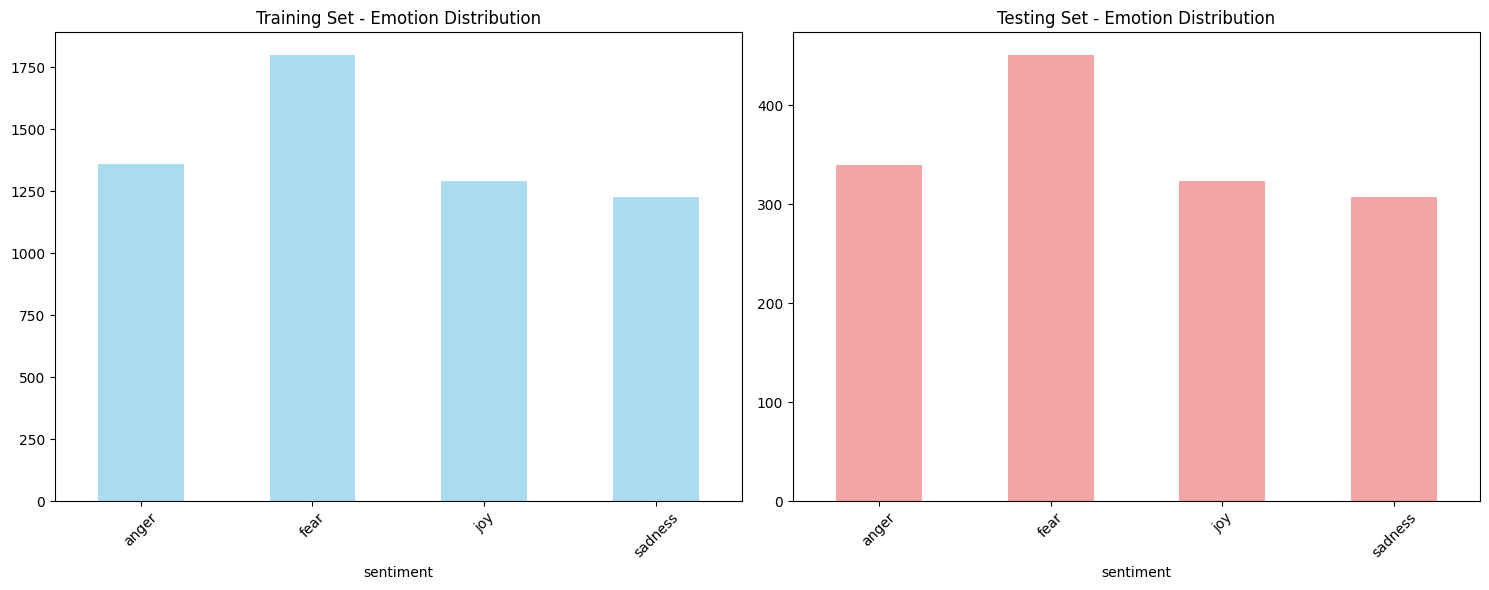


--- Melatih Model Machine Learning ---
--- Naive Bayes ---
              precision    recall  f1-score   support

         joy       0.88      0.72      0.79       323
     sadness       0.81      0.59      0.69       307
       anger       0.86      0.74      0.80       340
        fear       0.66      0.93      0.77       451

    accuracy                           0.76      1421
   macro avg       0.80      0.75      0.76      1421
weighted avg       0.79      0.76      0.76      1421

Inference Time: 0.0004s


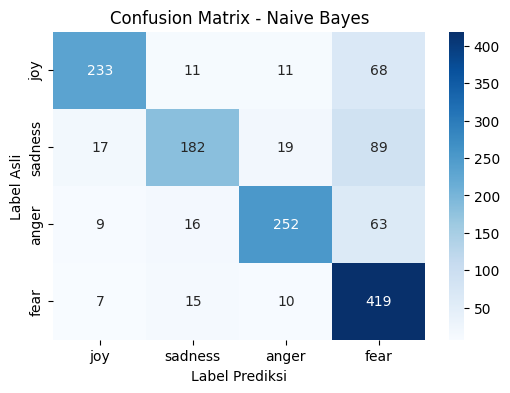

--- Support Vector Machine ---
              precision    recall  f1-score   support

         joy       0.91      0.84      0.87       323
     sadness       0.82      0.80      0.81       307
       anger       0.88      0.82      0.85       340
        fear       0.80      0.90      0.84       451

    accuracy                           0.84      1421
   macro avg       0.85      0.84      0.84      1421
weighted avg       0.85      0.84      0.84      1421

Inference Time: 0.8125s


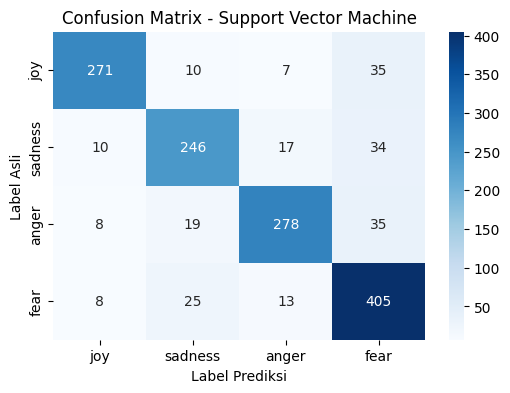

--- Random Forest ---
              precision    recall  f1-score   support

         joy       0.93      0.83      0.88       323
     sadness       0.86      0.76      0.80       307
       anger       0.90      0.80      0.84       340
        fear       0.74      0.92      0.82       451

    accuracy                           0.83      1421
   macro avg       0.86      0.83      0.84      1421
weighted avg       0.85      0.83      0.83      1421

Inference Time: 0.0636s


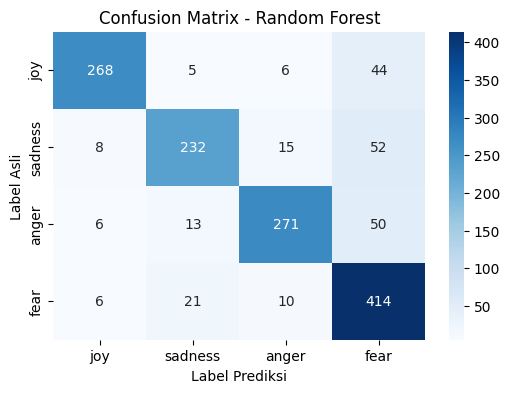


DEBUG: PROSES TOKENISASI DEEP LEARNING


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Teks Asli:
'@sidviyer uff!! Look at your Arsenal fans cheering for every goal against United. haha'

--- Hasil Tokenisasi ---
Tokens: ['[CLS]', '@', 'sid', '##vi', '##yer', 'u', '##ff', '!', '!', 'look', 'at', 'your', 'arsenal', 'fans', 'cheering', 'for', 'every', 'goal', 'against', 'united', '.', 'ha', '##ha', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Input IDs: tensor([  101,  1030, 15765,  5737, 10532,  1057,  4246,   999,   999,  2298,
         2012,  2115,  9433,  4599, 24867,  2005,  2296,  3125,  2114,  2142,
         1012,  5292,  3270,   102,     0,     0,     0,     0,     0,     0,
            0,     0])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0])


--- Melatih Model Deep Learning ---

--- BiLSTM ---
Epoch 1/20 | Train Loss: 1.2679 Acc: 0.4117 | Val Loss: 1.1024 Acc: 0.5186
Epoch 2/20 | Train Loss: 0.8111 Acc: 0.6869 | Val Loss: 0.8295 Acc: 0.6847
Epoch

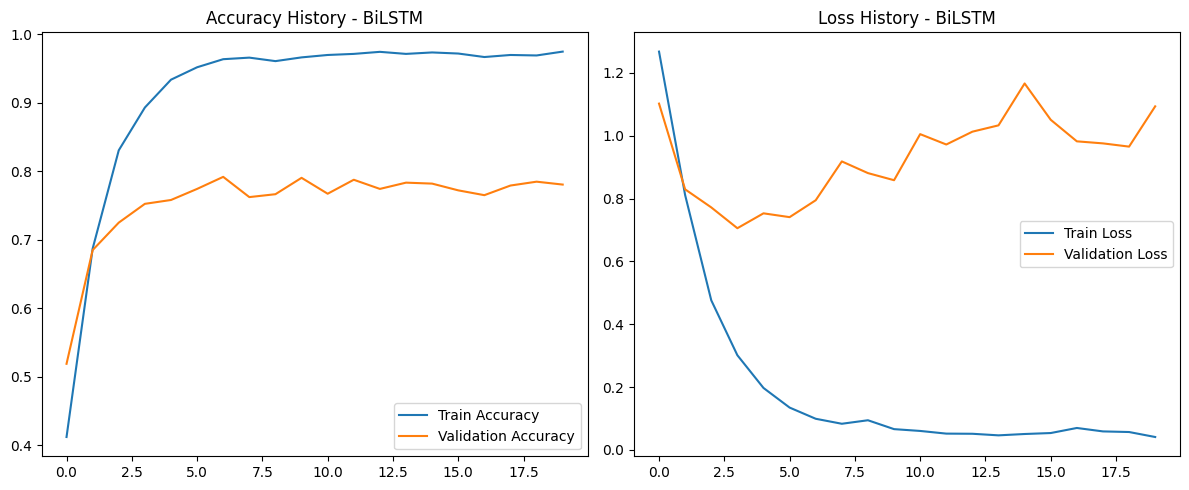

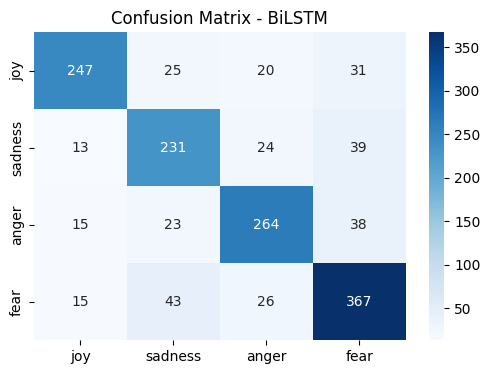


--- bert-base-uncased ---


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 | Train Loss: 0.9227 Acc: 0.5932 | Val Loss: 0.4407 Acc: 0.8452
Epoch 2/10 | Train Loss: 0.3196 Acc: 0.8852 | Val Loss: 0.3544 Acc: 0.8712
Epoch 3/10 | Train Loss: 0.1958 Acc: 0.9262 | Val Loss: 0.3583 Acc: 0.8684
Epoch 4/10 | Train Loss: 0.1233 Acc: 0.9530 | Val Loss: 0.4128 Acc: 0.8670
Epoch 5/10 | Train Loss: 0.0889 Acc: 0.9639 | Val Loss: 0.4471 Acc: 0.8642
Epoch 6/10 | Train Loss: 0.0758 Acc: 0.9678 | Val Loss: 0.4780 Acc: 0.8684
Epoch 7/10 | Train Loss: 0.0620 Acc: 0.9685 | Val Loss: 0.4998 Acc: 0.8684
Epoch 8/10 | Train Loss: 0.0574 Acc: 0.9706 | Val Loss: 0.4930 Acc: 0.8705
Epoch 9/10 | Train Loss: 0.0495 Acc: 0.9754 | Val Loss: 0.5127 Acc: 0.8705
Epoch 10/10 | Train Loss: 0.0485 Acc: 0.9745 | Val Loss: 0.5138 Acc: 0.8670

--- Evaluasi bert-base-uncased ---
              precision    recall  f1-score   support

         joy       0.95      0.88      0.91       323
     sadness       0.82      0.83      0.82       307
       anger       0.90      0.85      0.87       

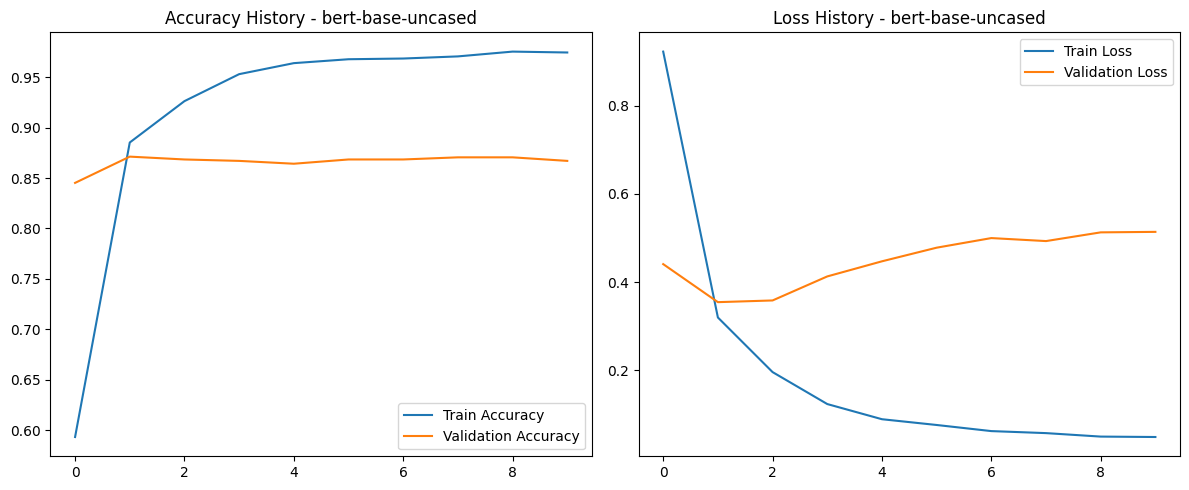

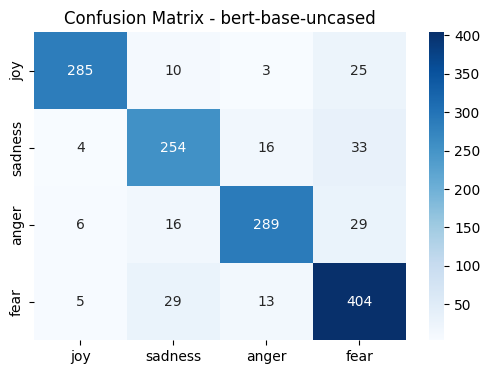


--- roberta-base ---


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 | Train Loss: 0.6907 Acc: 0.7272 | Val Loss: 0.4160 Acc: 0.8480
Epoch 2/10 | Train Loss: 0.3233 Acc: 0.8801 | Val Loss: 0.3198 Acc: 0.8719
Epoch 3/10 | Train Loss: 0.2377 Acc: 0.9092 | Val Loss: 0.3112 Acc: 0.8684
Epoch 4/10 | Train Loss: 0.1842 Acc: 0.9298 | Val Loss: 0.3416 Acc: 0.8733
Epoch 5/10 | Train Loss: 0.1393 Acc: 0.9458 | Val Loss: 0.3796 Acc: 0.8670
Epoch 6/10 | Train Loss: 0.1092 Acc: 0.9562 | Val Loss: 0.4188 Acc: 0.8677
Epoch 7/10 | Train Loss: 0.0875 Acc: 0.9607 | Val Loss: 0.4321 Acc: 0.8670
Epoch 8/10 | Train Loss: 0.0750 Acc: 0.9660 | Val Loss: 0.4606 Acc: 0.8712
Epoch 9/10 | Train Loss: 0.0672 Acc: 0.9713 | Val Loss: 0.4731 Acc: 0.8705
Epoch 10/10 | Train Loss: 0.0619 Acc: 0.9713 | Val Loss: 0.4651 Acc: 0.8698

--- Evaluasi roberta-base ---
              precision    recall  f1-score   support

         joy       0.92      0.89      0.91       323
     sadness       0.84      0.84      0.84       307
       anger       0.87      0.85      0.86       340
 

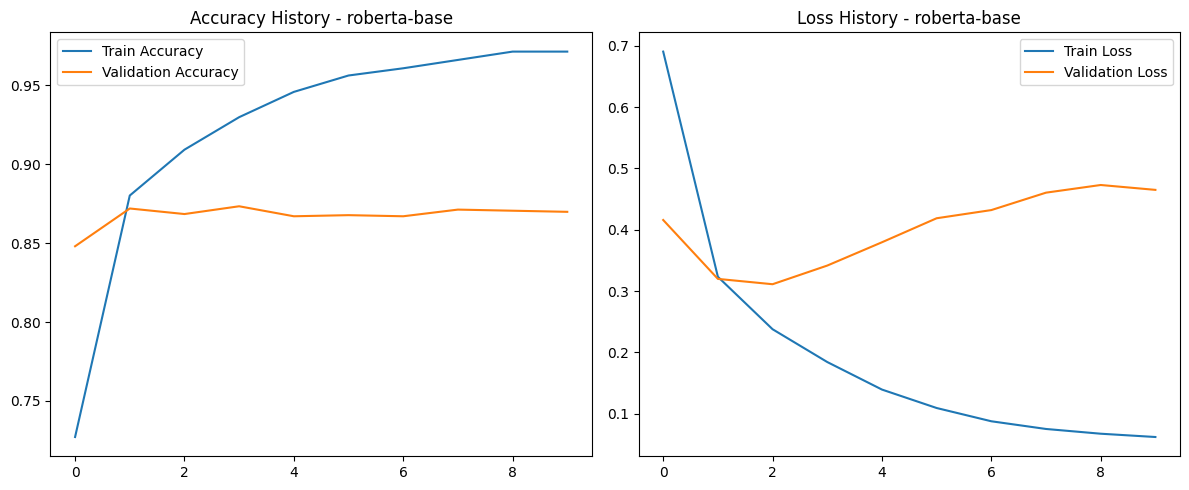

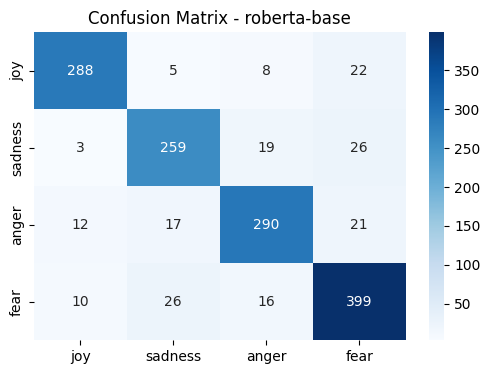


--- distilbert-base-uncased ---


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 | Train Loss: 0.7853 Acc: 0.6754 | Val Loss: 0.3752 Acc: 0.8677
Epoch 2/10 | Train Loss: 0.3041 Acc: 0.8970 | Val Loss: 0.3394 Acc: 0.8656
Epoch 3/10 | Train Loss: 0.2031 Acc: 0.9280 | Val Loss: 0.3531 Acc: 0.8670
Epoch 4/10 | Train Loss: 0.1415 Acc: 0.9488 | Val Loss: 0.3968 Acc: 0.8656
Epoch 5/10 | Train Loss: 0.1041 Acc: 0.9611 | Val Loss: 0.4128 Acc: 0.8698
Epoch 6/10 | Train Loss: 0.0791 Acc: 0.9655 | Val Loss: 0.4476 Acc: 0.8677
Epoch 7/10 | Train Loss: 0.0734 Acc: 0.9674 | Val Loss: 0.4656 Acc: 0.8691
Epoch 8/10 | Train Loss: 0.0664 Acc: 0.9688 | Val Loss: 0.4781 Acc: 0.8691
Epoch 9/10 | Train Loss: 0.0559 Acc: 0.9727 | Val Loss: 0.4842 Acc: 0.8670
Epoch 10/10 | Train Loss: 0.0532 Acc: 0.9754 | Val Loss: 0.4930 Acc: 0.8684

--- Evaluasi distilbert-base-uncased ---
              precision    recall  f1-score   support

         joy       0.93      0.89      0.91       323
     sadness       0.83      0.84      0.83       307
       anger       0.89      0.86      0.87 

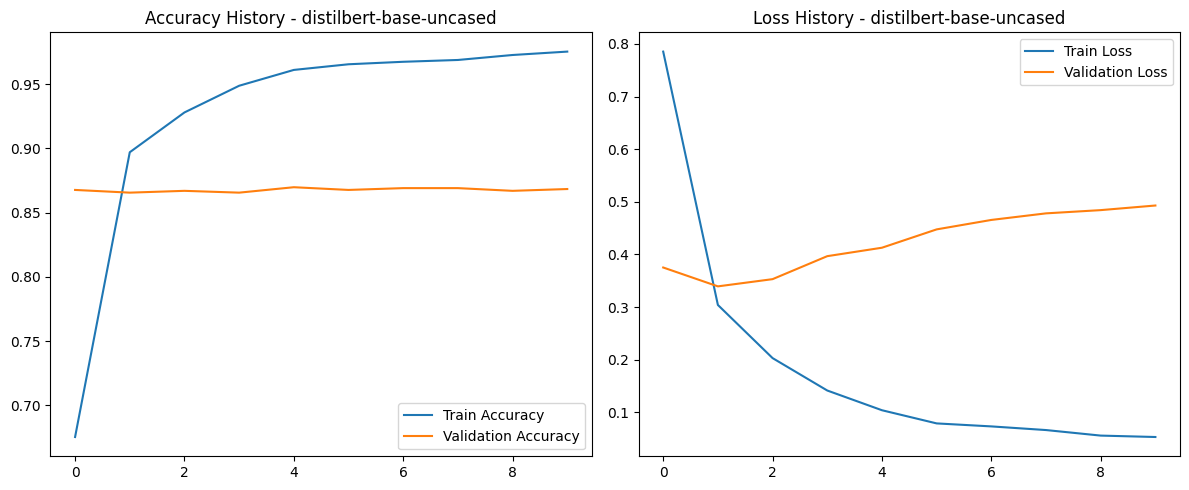

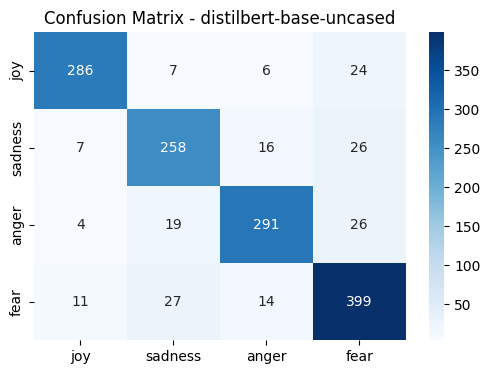


--- Semua Proses Selesai ---


In [ ]:
# ====== Import Pustaka yang Dibutuhkan ======

import pandas as pd
import numpy as np
import torch
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
from unicodedata import normalize
import nltk

import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix

# PyTorch & Transformers
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, AdamW
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    DistilBertTokenizer, DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup
)

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Menggunakan device: {device}")


# ====== 1. Memuat Data ======
# Ganti dengan path yang benar jika file tidak ada di direktori yang sama
try:
    df = pd.read_csv("eng_dataset.csv")
    df.drop(["ID"], axis=1, inplace=True, errors='ignore')
except FileNotFoundError:
    print("Error: Pastikan file 'eng_dataset.csv' berada di direktori yang sama.")
    # Exit atau handle error sesuai kebutuhan
    exit()

print("--- Data Asli yang Akan Digunakan ---")
print(df.head().to_markdown(index=False))

# ======================================================================
# PREPROCESSING MANUAL DISKIP SESUAI PERMINTAAN
# Kolom 'content' akan langsung digunakan
# ======================================================================

# Mapping label ke numerik
emotion_labels = {"joy": 0, "sadness": 1, "anger": 2, "fear": 3}
df['sentiment_encoded'] = df['sentiment'].map(emotion_labels)

# ====== 2. Pembagian Data (80:20) ======
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment_encoded']
)

print(f"\nUkuran Training Set: {df_train.shape[0]}")
print(f"Ukuran Testing Set: {df_test.shape[0]}")

# ====== Analisis Persebaran Emosi Setelah Split ======
print("\n--- Persebaran Emosi Setelah Split ---")
# (Visualisasi dan print persebaran tetap sama)
train_emotion_dist = df_train['sentiment'].value_counts().sort_index()
test_emotion_dist = df_test['sentiment'].value_counts().sort_index()
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
train_emotion_dist.plot(kind='bar', ax=axes[0], color='skyblue', alpha=0.7)
axes[0].set_title('Training Set - Emotion Distribution')
axes[0].tick_params(axis='x', rotation=45)
test_emotion_dist.plot(kind='bar', ax=axes[1], color='lightcoral', alpha=0.7)
axes[1].set_title('Testing Set - Emotion Distribution')
axes[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


# ====== 3. Ekstraksi Fitur & Model Machine Learning ======
print("\n--- Melatih Model Machine Learning ---")

# Ekstraksi Fitur TF-IDF dari kolom 'content' (teks asli)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['content']) # Menggunakan 'content'
X_test_tfidf = tfidf_vectorizer.transform(df_test['content'])     # Menggunakan 'content'
y_train = df_train['sentiment_encoded']
y_test = df_test['sentiment_encoded']

# Fungsi untuk evaluasi model ML
def evaluate_ml_model(model, X_test, y_test, model_name):
    start_time = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_time
    print(f"--- {model_name} ---")
    print(classification_report(y_test, y_pred, target_names=emotion_labels.keys()))
    print(f"Inference Time: {inference_time:.4f}s")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.keys(), yticklabels=emotion_labels.keys())
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Label Asli'); plt.xlabel('Label Prediksi')
    plt.show()

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
evaluate_ml_model(nb_model, X_test_tfidf, y_test, "Naive Bayes")

# SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_tfidf, y_train)
evaluate_ml_model(svm_model, X_test_tfidf, y_test, "Support Vector Machine")

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_tfidf, y_train)
evaluate_ml_model(rf_model, X_test_tfidf, y_test, "Random Forest")


# ====== 4. DEBUG TOKENISASI DEEP LEARNING ======
print("\n" + "="*50)
print("DEBUG: PROSES TOKENISASI DEEP LEARNING")
print("="*50)

# Inisialisasi tokenizer untuk debug (contoh: BERT)
debug_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
sample_text = df_train['content'].iloc[0] # Ambil satu sampel teks asli

# Tokenisasi sampel
encoding = debug_tokenizer.encode_plus(
  sample_text,
  add_special_tokens=True,
  max_length=32, # max_length pendek untuk contoh
  return_token_type_ids=False,
  padding='max_length',
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',
)

print(f"Teks Asli:\n'{sample_text}'")
print("\n--- Hasil Tokenisasi ---")
print(f"Tokens: {debug_tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])}")
print(f"Input IDs: {encoding['input_ids'][0]}")
print(f"Attention Mask: {encoding['attention_mask'][0]}")
print("="*50 + "\n")


# ====== 5. Model Deep Learning ======
print("\n--- Melatih Model Deep Learning ---")

# Helper classes and functions for PyTorch
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            return_token_type_ids=False, padding='max_length',
            truncation=True, return_attention_mask=True, return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = EmotionDataset(
        texts=df.content.to_numpy(),             # Menggunakan 'content'
        labels=df.sentiment_encoded.to_numpy(),
        tokenizer=tokenizer, max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=2)

def train_dl_epoch(model, data_loader, optimizer, device, scheduler):
    model = model.train()
    losses, correct_predictions, total_samples = [], 0, 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        _, preds = torch.max(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == labels).item()
        losses.append(loss.item())
        total_samples += labels.size(0)
        loss.backward()
        optimizer.step()
        scheduler.step()
    return correct_predictions / total_samples, np.mean(losses)

def eval_dl_model(model, data_loader, device):
    model = model.eval()
    losses, correct_predictions, total_samples = [], 0, 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            _, preds = torch.max(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels).item()
            losses.append(loss.item())
            total_samples += labels.size(0)
    return correct_predictions / total_samples, np.mean(losses)

def get_predictions(model, data_loader, device):
    model = model.eval()
    predictions, real_values = [], []
    start_time = time.time()
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            real_values.extend(labels.cpu().numpy())
    inference_time = time.time() - start_time
    return predictions, real_values, inference_time

def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'Accuracy History - {model_name}')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Loss History - {model_name}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# --- BiLSTM ---
print("\n--- BiLSTM ---")

# Hyperparameters
VOCAB_SIZE, EMBED_DIM, MAX_LEN_BILSTM = 10000, 128, 128
HIDDEN_DIM, OUTPUT_DIM = 128, len(emotion_labels)
EPOCHS_BILSTM, LEARNING_RATE_BILSTM = 20, 1e-3

# TensorFlow Tokenizer untuk BiLSTM
from tensorflow.keras.preprocessing.text import Tokenizer as KerasTokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer_bilstm = KerasTokenizer(num_words=VOCAB_SIZE, oov_token="<unk>")
tokenizer_bilstm.fit_on_texts(df_train['content']) # Menggunakan 'content'
X_train_seq = pad_sequences(tokenizer_bilstm.texts_to_sequences(df_train['content']), maxlen=MAX_LEN_BILSTM)
X_test_seq = pad_sequences(tokenizer_bilstm.texts_to_sequences(df_test['content']), maxlen=MAX_LEN_BILSTM)
y_train_tensor = torch.tensor(df_train['sentiment_encoded'].values, dtype=torch.long)
y_test_tensor = torch.tensor(df_test['sentiment_encoded'].values, dtype=torch.long)

# DataLoader untuk BiLSTM
train_data_bilstm = torch.utils.data.TensorDataset(torch.tensor(X_train_seq, dtype=torch.long), y_train_tensor)
train_loader_bilstm = DataLoader(train_data_bilstm, batch_size=32, shuffle=True)
test_data_bilstm = torch.utils.data.TensorDataset(torch.tensor(X_test_seq, dtype=torch.long), y_test_tensor)
test_loader_bilstm = DataLoader(test_data_bilstm, batch_size=32)

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers, bidirectional=True, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)

model_bilstm = BiLSTMClassifier(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
optimizer_bilstm = Adam(model_bilstm.parameters(), lr=LEARNING_RATE_BILSTM)
criterion_bilstm = nn.CrossEntropyLoss().to(device)
history_bilstm = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(EPOCHS_BILSTM):
    model_bilstm.train()
    epoch_loss, epoch_corrects, total_samples = 0, 0, 0
    for inputs, labels in train_loader_bilstm:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_bilstm.zero_grad()
        outputs = model_bilstm(inputs)
        loss = criterion_bilstm(outputs, labels)
        _, preds = torch.max(outputs, dim=1)
        loss.backward()
        optimizer_bilstm.step()
        epoch_loss += loss.item() * inputs.size(0)
        epoch_corrects += torch.sum(preds == labels.data).item()
        total_samples += inputs.size(0)
    train_loss = epoch_loss / total_samples
    train_acc = epoch_corrects / total_samples
    history_bilstm['train_loss'].append(train_loss); history_bilstm['train_acc'].append(train_acc)
    # Validation (di-loop BiLSTM)
    model_bilstm.eval()
    val_loss, val_corrects, val_samples = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader_bilstm:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_bilstm(inputs)
            loss = criterion_bilstm(outputs, labels)
            _, preds = torch.max(outputs, dim=1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data).item()
            val_samples += inputs.size(0)
    val_loss /= val_samples
    val_acc = val_corrects / val_samples
    history_bilstm['val_loss'].append(val_loss); history_bilstm['val_acc'].append(val_acc)
    print(f'Epoch {epoch+1}/{EPOCHS_BILSTM} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

# Evaluasi BiLSTM
bilstm_preds, bilstm_true, bilstm_inf_time = [], [], 0
start_time = time.time()
with torch.no_grad():
    for inputs, labels in test_loader_bilstm:
        outputs = model_bilstm(inputs.to(device))
        bilstm_preds.extend(torch.max(outputs, dim=1)[1].cpu().numpy())
        bilstm_true.extend(labels.cpu().numpy())
bilstm_inf_time = time.time() - start_time
print("\n--- Evaluasi BiLSTM ---")
print(classification_report(bilstm_true, bilstm_preds, target_names=emotion_labels.keys()))
print(f"Inference Time: {bilstm_inf_time:.4f}s")
plot_training_history(history_bilstm, "BiLSTM")
cm = confusion_matrix(bilstm_true, bilstm_preds)
plt.figure(figsize=(6, 4)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.keys(), yticklabels=emotion_labels.keys()); plt.title('Confusion Matrix - BiLSTM'); plt.show()

# --- Transformers (BERT, RoBERTa, DistilBERT) ---
def run_transformer_experiment(model_name, model_class, tokenizer_class):
    print(f"\n--- {model_name} ---")
    MAX_LEN, BATCH_SIZE, EPOCHS, LEARNING_RATE = 128, 16, 10, 2e-5
    tokenizer = tokenizer_class.from_pretrained(model_name)
    train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
    test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
    model = model_class.from_pretrained(model_name, num_labels=len(emotion_labels)).to(device)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_data_loader) * EPOCHS)
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(EPOCHS):
        train_acc, train_loss = train_dl_epoch(model, train_data_loader, optimizer, device, scheduler)
        val_acc, val_loss = eval_dl_model(model, test_data_loader, device)
        history['train_loss'].append(train_loss); history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)
        print(f'Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
    y_pred, y_true, inference_time = get_predictions(model, test_data_loader, device)
    print(f"\n--- Evaluasi {model_name} ---")
    print(classification_report(y_true, y_pred, target_names=emotion_labels.keys()))
    print(f"Inference Time: {inference_time:.4f}s")
    plot_training_history(history, model_name)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.keys(), yticklabels=emotion_labels.keys()); plt.title(f'Confusion Matrix - {model_name}'); plt.show()

run_transformer_experiment('bert-base-uncased', BertForSequenceClassification, BertTokenizer)
run_transformer_experiment('roberta-base', RobertaForSequenceClassification, RobertaTokenizer)
run_transformer_experiment('distilbert-base-uncased', DistilBertForSequenceClassification, DistilBertTokenizer)

print("\n--- Semua Proses Selesai ---")

#pakai debug ekstraksi fitur

Menggunakan device: cuda
--- Data Asli (Sebelum Preprocessing) ---
| sentiment   | content                                                                                                                                 |
|:------------|:----------------------------------------------------------------------------------------------------------------------------------------|
| anger       | At the point today where if someone says something remotely kind to me, a waterfall will burst out of my eyes                           |
| anger       | @CorningFootball  IT'S GAME DAY!!!!      T MINUS 14:30  #relentless                                                                     |
| anger       | This game has pissed me off more than any other game this year. My blood is boiling! Time to turn it off! #STLCards                     |
| anger       | @spamvicious I've just found out it's Candice and not Candace. She can pout all she likes for me ðŸ˜                                              

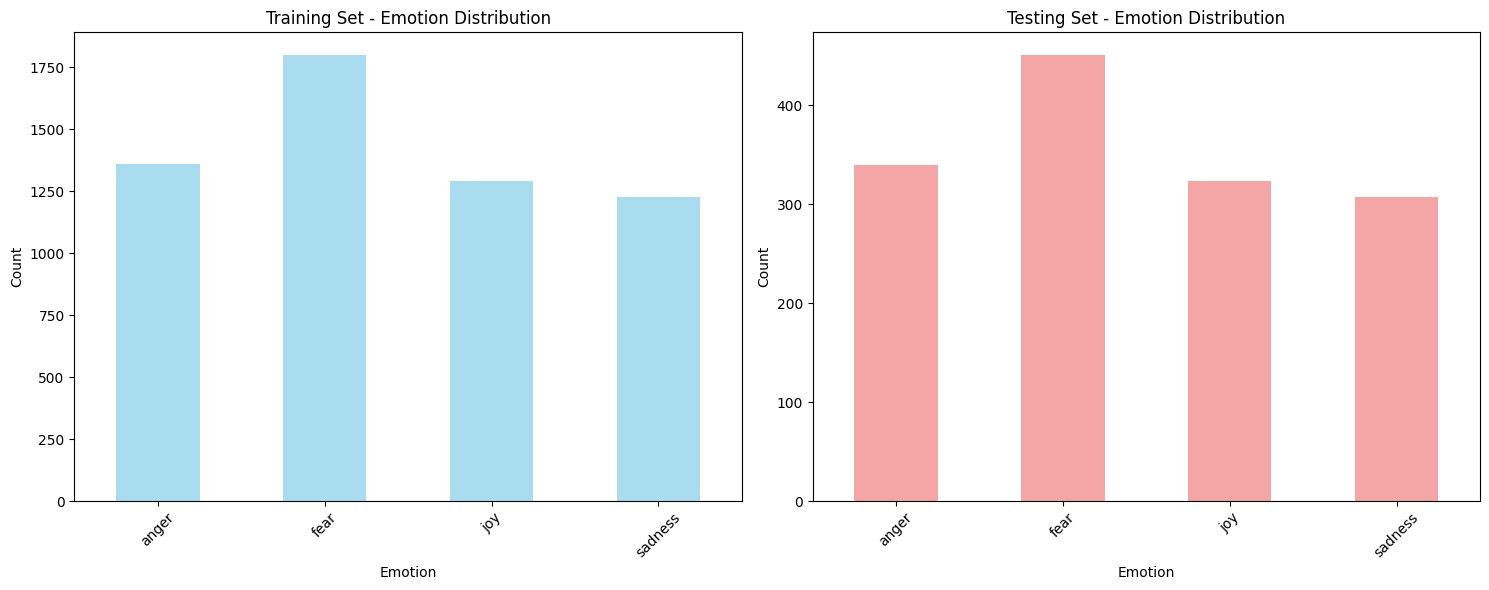


Total Dataset: 7102 samples
Training Set: 5681 samples (80.0%)
Testing Set: 1421 samples (20.0%)

--- Melatih Model Machine Learning ---

DEBUG: HASIL EKSTRAKSI FITUR TF-IDF

--- Teks SEBELUM di-vektorisasi (1 sampel) ---
Teks: 'sidviy uff look arsenal fan cheer everi goal unit'

--- Informasi Matriks SESUDAH di-vektorisasi ---
Bentuk (shape) dari matriks TF-IDF (data latih): (5681, 5000)

--- Contoh Representasi Vektor untuk Sampel Teks di Atas (LENGKAP) ---
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0. 

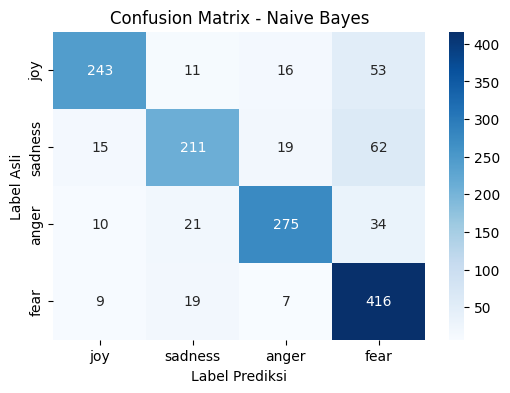

--- Support Vector Machine ---
              precision    recall  f1-score   support

         joy       0.90      0.84      0.87       323
     sadness       0.83      0.82      0.83       307
       anger       0.91      0.85      0.88       340
        fear       0.82      0.91      0.86       451

    accuracy                           0.86      1421
   macro avg       0.87      0.85      0.86      1421
weighted avg       0.86      0.86      0.86      1421

Accuracy: 0.8593
Precision: 0.8621
Recall: 0.8593
F1-score: 0.8594
Inference Time: 1.4132s


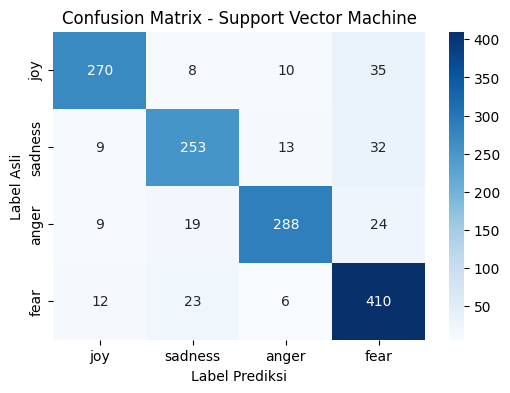

KeyboardInterrupt: 

In [ ]:
# ====== Import Pustaka yang Dibutuhkan ======

import pandas as pd
import numpy as np
import torch
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
from unicodedata import normalize
import nltk

import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix

# PyTorch & Transformers
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, AdamW
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    DistilBertTokenizer, DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup
)

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Menggunakan device: {device}")

# ====== 1. Fungsi Preprocessing ======
def preprocessing(text: str) -> str:
    """
    Membersihkan dan memproses teks mentah.
    """
    text = text.lower()
    text = " ".join(w for w in text.split()
                    if 'http://' not in w and 'https://' not in w
                    and '.com' not in w and '.es' not in w and w!='rt')
    text = re.sub(r'[@#]', '', text)
    text = re.sub(r'\b([jh]*[aeiou]*[jh]+[aeiou]*)*\b','',text)
    text = re.sub(r'(.)\1{2,}',r'\1', text)
    text = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+",
                  r"\1", normalize("NFD", text), flags=re.I)
    text = re.sub("[^a-zA-Z]"," ", text)
    text = re.sub(r"\s+"," ", text).strip()

    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    stemmer = SnowballStemmer('english')

    return " ".join(stemmer.stem(w) for w in tokens if w not in stop_words)

# ====== 2. Memuat dan Memproses Data ======
# Ganti dengan path yang benar jika file tidak ada di direktori yang sama
try:
    df = pd.read_csv("eng_dataset.csv")
    df.drop(["ID"], axis=1, inplace=True, errors='ignore')
except FileNotFoundError:
    print("Error: Pastikan file 'eng_dataset.csv' berada di direktori yang sama.")
    # Exit atau handle error sesuai kebutuhan
    exit()

print("--- Data Asli (Sebelum Preprocessing) ---")
print(df.head().to_markdown(index=False))

# Terapkan fungsi preprocessing
df['Processed_Content'] = df['content'].apply(preprocessing)

print("\n--- Data Setelah Preprocessing ---")
# Menampilkan kolom asli dan yang sudah diproses untuk perbandingan
print(df[['content', 'Processed_Content', 'sentiment']].head().to_markdown(index=False))

# Mapping label ke numerik
emotion_labels = {"joy": 0, "sadness": 1, "anger": 2, "fear": 3}
df['sentiment_encoded'] = df['sentiment'].map(emotion_labels)

# ====== 3. Pembagian Data (80:20) ======
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment_encoded']
)

print(f"\nUkuran Training Set: {df_train.shape[0]}")
print(f"Ukuran Testing Set: {df_test.shape[0]}")

# ====== Analisis Persebaran Emosi Setelah Split ======
print("\n--- Persebaran Emosi Setelah Split ---")

# Persebaran di Training Set
print("Training Set Distribution:")
train_emotion_dist = df_train['sentiment'].value_counts().sort_index()
print(train_emotion_dist)
print(f"Training Set Percentages:")
for emotion, count in train_emotion_dist.items():
    percentage = (count / len(df_train)) * 100
    print(f"{emotion}: {count} samples ({percentage:.2f}%)")

print("\nTesting Set Distribution:")
test_emotion_dist = df_test['sentiment'].value_counts().sort_index()
print(test_emotion_dist)
print(f"Testing Set Percentages:")
for emotion, count in test_emotion_dist.items():
    percentage = (count / len(df_test)) * 100
    print(f"{emotion}: {count} samples ({percentage:.2f}%)")

# Visualisasi persebaran emosi
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Training Set
train_emotion_dist.plot(kind='bar', ax=axes[0], color='skyblue', alpha=0.7)
axes[0].set_title('Training Set - Emotion Distribution')
axes[0].set_xlabel('Emotion')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Testing Set
test_emotion_dist.plot(kind='bar', ax=axes[1], color='lightcoral', alpha=0.7)
axes[1].set_title('Testing Set - Emotion Distribution')
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Ringkasan total
print(f"\nTotal Dataset: {len(df)} samples")
print(f"Training Set: {len(df_train)} samples ({(len(df_train)/len(df)*100):.1f}%)")
print(f"Testing Set: {len(df_test)} samples ({(len(df_test)/len(df)*100):.1f}%)")

# ====== 4. Ekstraksi Fitur & Model Machine Learning ======
print("\n--- Melatih Model Machine Learning ---")

# Ekstraksi Fitur TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['Processed_Content'])
X_test_tfidf = tfidf_vectorizer.transform(df_test['Processed_Content'])
y_train = df_train['sentiment_encoded']
y_test = df_test['sentiment_encoded']


####################################################################
## BLOK DEBUG BARU (DENGAN VEKTOR LENGKAP) ##
####################################################################
print("\n" + "="*50)
print("DEBUG: HASIL EKSTRAKSI FITUR TF-IDF")
print("="*50)

# 1. Tampilkan Teks SEBELUM Ekstraksi (Contoh 1 data dari set pelatihan)
print("\n--- Teks SEBELUM di-vektorisasi (1 sampel) ---")
sample_text_before = df_train['Processed_Content'].iloc[0]
print(f"Teks: '{sample_text_before}'")

# 2. Tampilkan Informasi Matriks SESUDAH Ekstraksi
print("\n--- Informasi Matriks SESUDAH di-vektorisasi ---")
print(f"Bentuk (shape) dari matriks TF-IDF (data latih): {X_train_tfidf.shape}")

# 3. Tampilkan Vektor TF-IDF untuk satu dokumen (FULL)
print("\n--- Contoh Representasi Vektor untuk Sampel Teks di Atas (LENGKAP) ---")

# DITAMBAHKAN: Atur opsi cetak untuk menampilkan seluruh array
import numpy as np
np.set_printoptions(threshold=np.inf)

# Ubah baris pertama dari matriks sparse menjadi array padat
vector_after = X_train_tfidf[0].toarray()[0]

# Cetak seluruh vektornya tanpa singkatan
print(vector_after)
print(f"Panjang vektor: {len(vector_after)} elemen.")

# (Opsional) Kembalikan ke pengaturan default setelahnya
# np.set_printoptions(threshold=1000)

# 4. Tampilkan Detail Skor yang Tidak Nol (untuk kemudahan membaca)
print("\n--- Term dan Skor TF-IDF yang Bernilai > 0 untuk Sampel Teks ---")
feature_names = tfidf_vectorizer.get_feature_names_out()
df_tfidf_sample = pd.DataFrame({'Term': feature_names, 'TF-IDF Score': vector_after})
print(df_tfidf_sample[df_tfidf_sample['TF-IDF Score'] > 0].to_markdown(index=False))

print("\n" + "="*50)
####################################################################
## AKHIR BLOK DEBUG ##
####################################################################

# Fungsi untuk evaluasi model ML
def evaluate_ml_model(model, X_test, y_test, model_name):
    start_time = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_time

    print(f"--- {model_name} ---")
    print(classification_report(y_test, y_pred, target_names=emotion_labels.keys()))

    # Metrik individu
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Inference Time: {inference_time:.4f}s")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.keys(), yticklabels=emotion_labels.keys())
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Label Asli')
    plt.xlabel('Label Prediksi')
    plt.show()

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
evaluate_ml_model(nb_model, X_test_tfidf, y_test, "Naive Bayes")

# SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_tfidf, y_train)
evaluate_ml_model(svm_model, X_test_tfidf, y_test, "Support Vector Machine")

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_tfidf, y_train)
evaluate_ml_model(rf_model, X_test_tfidf, y_test, "Random Forest")


# ====== 5. Model Deep Learning ======
print("\n--- Melatih Model Deep Learning ---")

# Helper classes and functions for PyTorch
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = EmotionDataset(
        texts=df.Processed_Content.to_numpy(),
        labels=df.sentiment_encoded.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=2)

def train_dl_epoch(model, data_loader, optimizer, device, scheduler):
    model = model.train()
    losses = []
    correct_predictions = 0
    total_samples = 0 # Keep track of total samples
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        total_samples += labels.size(0) # Add batch size to total samples

        loss.backward()
        optimizer.step()
        scheduler.step()

    # Move to CPU and get item for scalar values
    return correct_predictions.double().cpu().item() / total_samples, np.mean(losses)

def eval_dl_model(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0
    total_samples = 0 # Keep track of total samples
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            total_samples += labels.size(0) # Add batch size to total samples

    # Move to CPU and get item for scalar values
    return correct_predictions.double().cpu().item() / total_samples, np.mean(losses)

def get_predictions(model, data_loader, device):
    model = model.eval()
    predictions = []
    real_values = []
    start_time = time.time()
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            predictions.extend(preds.cpu().numpy()) # Move predictions to CPU
            real_values.extend(labels.cpu().numpy()) # Move labels to CPU

    inference_time = time.time() - start_time
    return predictions, real_values, inference_time

def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    # Ensure data is on CPU before plotting
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'Accuracy History - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
     # Ensure data is on CPU before plotting
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Loss History - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- BiLSTM ---
print("\n--- BiLSTM ---")

# Hyperparameters
VOCAB_SIZE = 10000
EMBED_DIM = 128
MAX_LEN_BILSTM = 128
HIDDEN_DIM = 128
OUTPUT_DIM = len(emotion_labels)
EPOCHS_BILSTM = 20
LEARNING_RATE_BILSTM = 1e-3

# BiLSTM Model Definition
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=True, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, input_ids, attention_mask=None): # attention_mask is for compatibility
        embedded = self.embedding(input_ids)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        # Ensure hidden state is on CPU before concatenation if needed later for CPU ops, but for FC it's fine on GPU
        # For this model, the hidden state remains on the device for the linear layer
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)

# Tokenizer untuk BiLSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer_bilstm = Tokenizer(num_words=VOCAB_SIZE, oov_token="<unk>")
tokenizer_bilstm.fit_on_texts(df_train['Processed_Content'])
X_train_seq = pad_sequences(tokenizer_bilstm.texts_to_sequences(df_train['Processed_Content']), maxlen=MAX_LEN_BILSTM)
X_test_seq = pad_sequences(tokenizer_bilstm.texts_to_sequences(df_test['Processed_Content']), maxlen=MAX_LEN_BILSTM)
y_train_tensor = torch.tensor(df_train['sentiment_encoded'].values, dtype=torch.long)
y_test_tensor = torch.tensor(df_test['sentiment_encoded'].values, dtype=torch.long)

# DataLoader untuk BiLSTM
train_data_bilstm = torch.utils.data.TensorDataset(torch.tensor(X_train_seq, dtype=torch.long), y_train_tensor)
train_loader_bilstm = DataLoader(train_data_bilstm, batch_size=32, shuffle=True)
test_data_bilstm = torch.utils.data.TensorDataset(torch.tensor(X_test_seq, dtype=torch.long), y_test_tensor)
test_loader_bilstm = DataLoader(test_data_bilstm, batch_size=32)

# Training BiLSTM
model_bilstm = BiLSTMClassifier(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
optimizer_bilstm = Adam(model_bilstm.parameters(), lr=LEARNING_RATE_BILSTM)
criterion_bilstm = nn.CrossEntropyLoss().to(device)

history_bilstm = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(EPOCHS_BILSTM):
    model_bilstm.train()
    epoch_loss, epoch_corrects = 0, 0
    total_samples = 0 # Keep track of total samples
    for inputs, labels in train_loader_bilstm:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_bilstm.zero_grad()
        outputs = model_bilstm(inputs)
        loss = criterion_bilstm(outputs, labels)
        _, preds = torch.max(outputs, dim=1)
        loss.backward()
        optimizer_bilstm.step()

        epoch_loss += loss.item() * inputs.size(0)
        epoch_corrects += torch.sum(preds == labels.data).item()
        total_samples += inputs.size(0) # Add batch size to total samples

    train_loss = epoch_loss / total_samples
    train_acc = epoch_corrects / total_samples
    history_bilstm['train_loss'].append(train_loss)
    history_bilstm['train_acc'].append(train_acc)

    # Validation
    model_bilstm.eval()
    val_loss, val_corrects = 0, 0
    val_samples = 0 # Keep track of total samples
    with torch.no_grad():
        for inputs, labels in test_loader_bilstm:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_bilstm(inputs)
            loss = criterion_bilstm(outputs, labels)
            _, preds = torch.max(outputs, dim=1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data).item()
            val_samples += inputs.size(0) # Add batch size to total samples

    val_loss = val_loss / val_samples
    val_acc = val_corrects / val_samples
    history_bilstm['val_loss'].append(val_loss)
    history_bilstm['val_acc'].append(val_acc)

    print(f'Epoch {epoch+1}/{EPOCHS_BILSTM} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

# Evaluasi BiLSTM
model_bilstm.eval()
bilstm_preds, bilstm_true, bilstm_inf_time = [], [], 0
start_time = time.time()
with torch.no_grad():
    for inputs, labels in test_loader_bilstm:
        inputs = inputs.to(device)
        outputs = model_bilstm(inputs)
        _, preds = torch.max(outputs, dim=1)
        bilstm_preds.extend(preds.cpu().numpy()) # Move predictions to CPU
        bilstm_true.extend(labels.cpu().numpy()) # Move labels to CPU
bilstm_inf_time = time.time() - start_time

print("\n--- Evaluasi BiLSTM ---")
print(classification_report(bilstm_true, bilstm_preds, target_names=emotion_labels.keys()))
print(f"Inference Time: {bilstm_inf_time:.4f}s")
plot_training_history(history_bilstm, "BiLSTM")
cm = confusion_matrix(bilstm_true, bilstm_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.keys(), yticklabels=emotion_labels.keys())
plt.title('Confusion Matrix - BiLSTM')
plt.show()

# --- Transformers (BERT, RoBERTa, DistilBERT) ---
def run_transformer_experiment(model_name, model_class, tokenizer_class):
    print(f"\n--- {model_name} ---")

    # Hyperparameters
    MAX_LEN = 128
    BATCH_SIZE = 16
    EPOCHS = 10 # Lowering epochs for faster testing, adjust as needed
    LEARNING_RATE = 2e-5

    # Setup
    tokenizer = tokenizer_class.from_pretrained(model_name)
    train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
    test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

    model = model_class.from_pretrained(model_name, num_labels=len(emotion_labels)).to(device)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_data_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Training Loop
    for epoch in range(EPOCHS):
        train_acc, train_loss = train_dl_epoch(model, train_data_loader, optimizer, device, scheduler)
        val_acc, val_loss = eval_dl_model(model, test_data_loader, device)

        # Move to CPU and get scalar value before appending
        history['train_loss'].append(train_loss) # Loss is already a Python float
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss) # Loss is already a Python float
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    # Evaluation
    y_pred, y_true, inference_time = get_predictions(model, test_data_loader, device)
    print(f"\n--- Evaluasi {model_name} ---")
    print(classification_report(y_true, y_pred, target_names=emotion_labels.keys()))
    print(f"Inference Time: {inference_time:.4f}s")

    plot_training_history(history, model_name)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.keys(), yticklabels=emotion_labels.keys())
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Menjalankan eksperimen untuk setiap model Transformer
run_transformer_experiment('bert-base-uncased', BertForSequenceClassification, BertTokenizer)
run_transformer_experiment('roberta-base', RobertaForSequenceClassification, RobertaTokenizer)
run_transformer_experiment('distilbert-base-uncased', DistilBertForSequenceClassification, DistilBertTokenizer)

print("\n--- Semua Proses Selesai ---")

#tokenizer biLSTM pake bert punya

Menggunakan device: cuda
--- Data Asli (Sebelum Preprocessing) ---
| sentiment   | content                                                                                                                                 |
|:------------|:----------------------------------------------------------------------------------------------------------------------------------------|
| anger       | At the point today where if someone says something remotely kind to me, a waterfall will burst out of my eyes                           |
| anger       | @CorningFootball  IT'S GAME DAY!!!!      T MINUS 14:30  #relentless                                                                     |
| anger       | This game has pissed me off more than any other game this year. My blood is boiling! Time to turn it off! #STLCards                     |
| anger       | @spamvicious I've just found out it's Candice and not Candace. She can pout all she likes for me ðŸ˜                                              

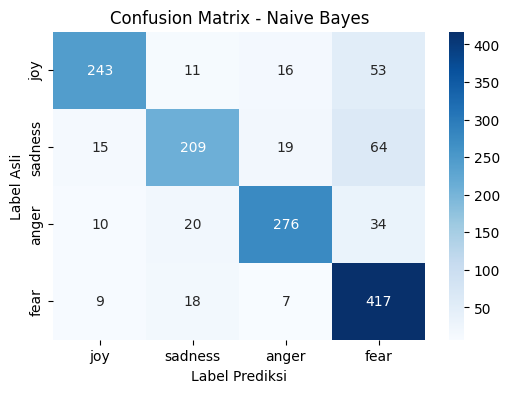

--- Support Vector Machine ---
              precision    recall  f1-score   support

         joy       0.90      0.84      0.87       323
     sadness       0.84      0.81      0.82       307
       anger       0.90      0.85      0.87       340
        fear       0.81      0.91      0.86       451

    accuracy                           0.86      1421
   macro avg       0.86      0.85      0.86      1421
weighted avg       0.86      0.86      0.86      1421

Accuracy: 0.8564
Precision: 0.8593
Recall: 0.8564
F1-score: 0.8565
Inference Time: 0.9148s


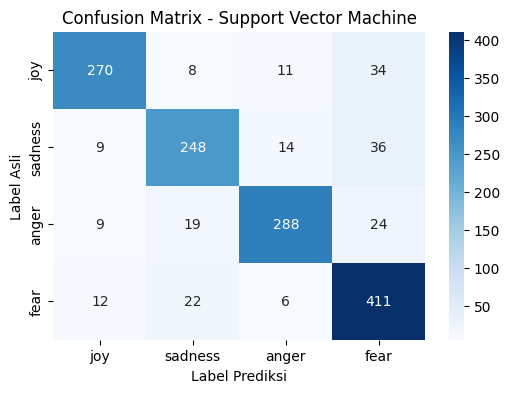

--- Random Forest ---
              precision    recall  f1-score   support

         joy       0.89      0.84      0.86       323
     sadness       0.86      0.78      0.82       307
       anger       0.92      0.81      0.86       340
        fear       0.77      0.92      0.84       451

    accuracy                           0.85      1421
   macro avg       0.86      0.84      0.85      1421
weighted avg       0.85      0.85      0.85      1421

Accuracy: 0.8459
Precision: 0.8533
Recall: 0.8459
F1-score: 0.8462
Inference Time: 0.1048s


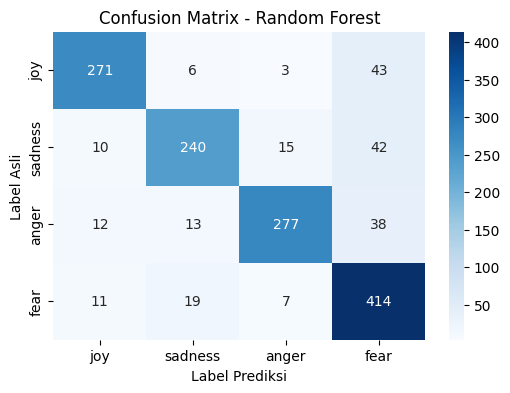


--- Melatih Model Deep Learning ---

--- BiLSTM ---
Menggunakan BertTokenizer untuk BiLSTM...
Epoch 1/20 | Train Loss: 1.2753 Acc: 0.4186 | Val Loss: 1.0605 Acc: 0.5778
Epoch 2/20 | Train Loss: 0.7969 Acc: 0.7097 | Val Loss: 0.8869 Acc: 0.6714
Epoch 3/20 | Train Loss: 0.4843 Acc: 0.8372 | Val Loss: 0.7624 Acc: 0.7389
Epoch 4/20 | Train Loss: 0.3265 Acc: 0.8953 | Val Loss: 0.7751 Acc: 0.7664
Epoch 5/20 | Train Loss: 0.2280 Acc: 0.9268 | Val Loss: 0.7564 Acc: 0.7875
Epoch 6/20 | Train Loss: 0.1592 Acc: 0.9479 | Val Loss: 0.7827 Acc: 0.7875
Epoch 7/20 | Train Loss: 0.1169 Acc: 0.9604 | Val Loss: 0.8345 Acc: 0.7741
Epoch 8/20 | Train Loss: 0.0967 Acc: 0.9627 | Val Loss: 0.9955 Acc: 0.7495
Epoch 9/20 | Train Loss: 0.1010 Acc: 0.9569 | Val Loss: 0.9567 Acc: 0.7734
Epoch 10/20 | Train Loss: 0.0962 Acc: 0.9620 | Val Loss: 0.9642 Acc: 0.7692
Epoch 11/20 | Train Loss: 0.0677 Acc: 0.9687 | Val Loss: 1.0834 Acc: 0.7797
Epoch 12/20 | Train Loss: 0.0671 Acc: 0.9683 | Val Loss: 1.0570 Acc: 0.7685
Ep

ValueError: too many values to unpack (expected 2)

In [ ]:
# ====== Import Pustaka yang Dibutuhkan ======
import pandas as pd
import numpy as np
import torch
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
from unicodedata import normalize
import nltk

import nltk
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix

# PyTorch & Transformers
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam, AdamW
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    DistilBertTokenizer, DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup
)

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Menggunakan device: {device}")

# ====== 1. Fungsi Preprocessing ======
def preprocessing(text: str) -> str:
    """
    Membersihkan dan memproses teks mentah.
    """
    text = text.lower()
    text = " ".join(w for w in text.split()
                    if 'http://' not in w and 'https://' not in w
                    and '.com' not in w and '.es' not in w and w!='rt')
    text = re.sub(r'[@#]', '', text)
    text = re.sub(r'\b([jh]*[aeiou]*[jh]+[aeiou]*)*\b','',text)
    text = re.sub(r'(.)\1{2,}',r'\1', text)
    text = re.sub(r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+",
                  r"\1", normalize("NFD", text), flags=re.I)
    text = re.sub("[^a-zA-Z]"," ", text)
    text = re.sub(r"\s+"," ", text).strip()

    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    stemmer = SnowballStemmer('english')

    return " ".join(stemmer.stem(w) for w in tokens if w not in stop_words)

# ====== 2. Memuat dan Memproses Data ======
# Ganti dengan path yang benar jika file tidak ada di direktori yang sama
try:
    df = pd.read_csv("eng_dataset.csv")
    df.drop(["ID"], axis=1, inplace=True, errors='ignore')
except FileNotFoundError:
    print("Error: Pastikan file 'eng_dataset.csv' berada di direktori yang sama.")
    # Exit atau handle error sesuai kebutuhan
    exit()

print("--- Data Asli (Sebelum Preprocessing) ---")
print(df.head().to_markdown(index=False))

# Terapkan fungsi preprocessing
df['Processed_Content'] = df['content'].apply(preprocessing)

print("\n--- Data Setelah Preprocessing ---")
# Menampilkan kolom asli dan yang sudah diproses untuk perbandingan
print(df[['content', 'Processed_Content', 'sentiment']].head().to_markdown(index=False))

# Mapping label ke numerik
emotion_labels = {"joy": 0, "sadness": 1, "anger": 2, "fear": 3}
df['sentiment_encoded'] = df['sentiment'].map(emotion_labels)

# ====== 3. Pembagian Data (80:20) ======
df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment_encoded']
)

print(f"\nUkuran Training Set: {df_train.shape[0]}")
print(f"Ukuran Testing Set: {df_test.shape[0]}")

# ====== 4. Ekstraksi Fitur & Model Machine Learning ======
print("\n--- Melatih Model Machine Learning ---")

# Ekstraksi Fitur TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train['Processed_Content'])
X_test_tfidf = tfidf_vectorizer.transform(df_test['Processed_Content'])
y_train = df_train['sentiment_encoded']
y_test = df_test['sentiment_encoded']

# Fungsi untuk evaluasi model ML
def evaluate_ml_model(model, X_test, y_test, model_name):
    start_time = time.time()
    y_pred = model.predict(X_test)
    inference_time = time.time() - start_time

    print(f"--- {model_name} ---")
    print(classification_report(y_test, y_pred, target_names=emotion_labels.keys()))

    # Metrik individu
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Inference Time: {inference_time:.4f}s")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.keys(), yticklabels=emotion_labels.keys())
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Label Asli')
    plt.xlabel('Label Prediksi')
    plt.show()

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
evaluate_ml_model(nb_model, X_test_tfidf, y_test, "Naive Bayes")

# SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_tfidf, y_train)
evaluate_ml_model(svm_model, X_test_tfidf, y_test, "Support Vector Machine")

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_tfidf, y_train)
evaluate_ml_model(rf_model, X_test_tfidf, y_test, "Random Forest")


# ====== 5. Model Deep Learning ======
print("\n--- Melatih Model Deep Learning ---")

# Helper classes and functions for PyTorch
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = EmotionDataset(
        texts=df.Processed_Content.to_numpy(),
        labels=df.sentiment_encoded.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=2)

def train_dl_epoch(model, data_loader, optimizer, device, scheduler):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

def eval_dl_model(model, data_loader, device):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

def get_predictions(model, data_loader, device):
    model = model.eval()
    predictions = []
    real_values = []
    start_time = time.time()
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)

            predictions.extend(preds)
            real_values.extend(labels)
    inference_time = time.time() - start_time
    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, real_values, inference_time

def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title(f'Accuracy History - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Loss History - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# --- BiLSTM dengan Tokenizer dari BERT ---
print("\n--- BiLSTM ---")

# Hyperparameters (sebagian besar tetap sama)
EMBED_DIM = 128
HIDDEN_DIM = 128
OUTPUT_DIM = len(emotion_labels)
EPOCHS_BILSTM = 20
LEARNING_RATE_BILSTM = 1e-3
MAX_LEN_BILSTM = 128
BATCH_SIZE_BILSTM = 32 # Bisa disesuaikan

# BiLSTM Model Definition (Tidak ada perubahan di sini)
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers=2, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=n_layers,
                            bidirectional=True, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, input_ids, attention_mask=None): # attention_mask untuk kompatibilitas
        embedded = self.embedding(input_ids)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)

# --- Perubahan Utama di Bagian Ini ---

# 1. Gunakan BertTokenizer dan reuse create_data_loader
print("Menggunakan BertTokenizer untuk BiLSTM...")
tokenizer_bilstm = BertTokenizer.from_pretrained('bert-base-uncased')
train_loader_bilstm = create_data_loader(df_train, tokenizer_bilstm, MAX_LEN_BILSTM, BATCH_SIZE_BILSTM)
test_loader_bilstm = create_data_loader(df_test, tokenizer_bilstm, MAX_LEN_BILSTM, BATCH_SIZE_BILSTM)

# 2. Sesuaikan VOCAB_SIZE dengan tokenizer baru
VOCAB_SIZE = tokenizer_bilstm.vocab_size

# 3. Inisialisasi model, optimizer, dan loss function
model_bilstm = BiLSTMClassifier(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
optimizer_bilstm = Adam(model_bilstm.parameters(), lr=LEARNING_RATE_BILSTM)
criterion_bilstm = nn.CrossEntropyLoss().to(device)

# --- Training Loop (Sedikit Penyesuaian) ---
history_bilstm = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(EPOCHS_BILSTM):
    model_bilstm.train()
    epoch_loss, epoch_corrects, epoch_samples = 0, 0, 0
    # Sesuaikan dengan output dari create_data_loader
    for batch in train_loader_bilstm:
        inputs = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)

        optimizer_bilstm.zero_grad()
        outputs = model_bilstm(inputs)
        loss = criterion_bilstm(outputs, labels)
        _, preds = torch.max(outputs, dim=1)
        loss.backward()
        optimizer_bilstm.step()

        epoch_loss += loss.item() * inputs.size(0)
        epoch_corrects += torch.sum(preds == labels.data).item()
        epoch_samples += inputs.size(0)

    train_loss = epoch_loss / epoch_samples
    train_acc = epoch_corrects / epoch_samples
    history_bilstm['train_loss'].append(train_loss)
    history_bilstm['train_acc'].append(train_acc)

    # Validation
    model_bilstm.eval()
    val_loss, val_corrects, val_samples = 0, 0, 0
    with torch.no_grad():
        for batch in test_loader_bilstm:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            outputs = model_bilstm(inputs)
            loss = criterion_bilstm(outputs, labels)
            _, preds = torch.max(outputs, dim=1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data).item()
            val_samples += inputs.size(0)

    val_loss = val_loss / val_samples
    val_acc = val_corrects / val_samples
    history_bilstm['val_loss'].append(val_loss)
    history_bilstm['val_acc'].append(val_acc)

    print(f'Epoch {epoch+1}/{EPOCHS_BILSTM} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

# Evaluasi BiLSTM
model_bilstm.eval()
bilstm_preds, bilstm_true, bilstm_inf_time = [], [], 0
start_time = time.time()
with torch.no_grad():
    for inputs, labels in test_loader_bilstm:
        inputs = inputs.to(device)
        outputs = model_bilstm(inputs)
        _, preds = torch.max(outputs, dim=1)
        bilstm_preds.extend(preds.cpu().numpy())
        bilstm_true.extend(labels.numpy())
bilstm_inf_time = time.time() - start_time

print("\n--- Evaluasi BiLSTM ---")
print(classification_report(bilstm_true, bilstm_preds, target_names=emotion_labels.keys()))
print(f"Inference Time: {bilstm_inf_time:.4f}s")
plot_training_history(history_bilstm, "BiLSTM")
cm = confusion_matrix(bilstm_true, bilstm_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.keys(), yticklabels=emotion_labels.keys())
plt.title('Confusion Matrix - BiLSTM')
plt.show()

# --- Transformers (BERT, RoBERTa, DistilBERT) ---
def run_transformer_experiment(model_name, model_class, tokenizer_class):
    print(f"\n--- {model_name} ---")

    # Hyperparameters
    MAX_LEN = 128
    BATCH_SIZE = 16
    EPOCHS = 10
    LEARNING_RATE = 2e-5

    # Setup
    tokenizer = tokenizer_class.from_pretrained(model_name)
    train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
    test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

    model = model_class.from_pretrained(model_name, num_labels=len(emotion_labels)).to(device)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    total_steps = len(train_data_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    # Training Loop
    for epoch in range(EPOCHS):
        train_acc, train_loss = train_dl_epoch(model, train_data_loader, optimizer, device, scheduler)
        val_acc, val_loss = eval_dl_model(model, test_data_loader, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    # Evaluation
    y_pred, y_true, inference_time = get_predictions(model, test_data_loader, device)
    print(f"\n--- Evaluasi {model_name} ---")
    print(classification_report(y_true, y_pred, target_names=emotion_labels.keys()))
    print(f"Inference Time: {inference_time:.4f}s")

    plot_training_history(history, model_name)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels.keys(), yticklabels=emotion_labels.keys())
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Menjalankan eksperimen untuk setiap model Transformer
run_transformer_experiment('bert-base-uncased', BertForSequenceClassification, BertTokenizer)
run_transformer_experiment('roberta-base', RobertaForSequenceClassification, RobertaTokenizer)
run_transformer_experiment('distilbert-base-uncased', DistilBertForSequenceClassification, DistilBertTokenizer)

print("\n--- Semua Proses Selesai ---")